# Generating Images with Generative Adversarial Networks (GANs)

The purpose of the project is to test the ability of Generative Adversial Networks (GANs) in generating realistic-looking images.

## Dataset

The dataset used will be FashionMNIST. It contains low resolution ($28 \times 28$) grey-scale images representing different kind of clothes. The dataset is available on keras and accessable in $\texttt{tf.keras.datasets.fashion\_mnist}$. Note that the pixel values for the images are initially in the interval $[0, 255]$. It is required to normalize them since all of the algorithm we will use require them to be in that format.

## Metrics

Measuring the quality of newly generated images is a non-trivial task. Indeed, there is no label associated to each image, and thus it is impossible to measure the quality image-by-image. For that reason, common metrics uses statistical consideration on a generated dataset to test how well the network recovered the statistics of the original data. One of the most common is the Fréchet Inception Distance (FID). The idea of FID is that in a realistic-looking dataset of images, the statistics of the activation of the last hidden layer in a well-trained classificator should be similar to that of a dataset containing real images. Specifically, regarding FID, the Inception-v3 network is used as a classificator. A real dataset $\mathbb{D}_r$ and a generated dataset $\mathbb{D}_g$ are processed by the network, and the activation of the last hidden layer has mean and variance $(\mu_r, \Sigma_r)$, $(\mu_g, \Sigma_g)$ respectively. Then, FID is computed as:

$$
    FID(\mathbb{D}_r, \mathbb{D}_g) = || \mu_r - \mu_g ||^2 + Tr(\Sigma_r + \Sigma_g - 2(\Sigma_r \ast \Sigma_g)^{\frac{1}{2}})
$$

A Python implementation of FID can be found in the file $\texttt{fid.py}$ that you find attached on Virtuale. Its usage is very simple, just generate $10k$ fake images with your GAN, and with the command $\texttt{fid.get\_fid(x\_test, x\_gen)}$, where $\texttt{x\_test}$ is the test set, containing $10k$ real images, you get the value for the FID of your network. Remember that, when passed through that function, $\texttt{x\_gen}$ **must** be a dataset of $10k$ images, in the interval $[0, 1]$. The number of $10k$ images is fundamental, since the value of FID strongly depends on the number of input images.

## Limitations

You are required to implement a vanilla Generative Adversarial Network (GAN), not a variant of it (e.g. PixelGAN, CycleGAN, ... are **not** accepted). The maximum number of parameters is *15 million*, and every pre-trained network can be used as an add-on (the number of parameters for pre-trained network does not count). Clearly, only the training set can be used to train the network, no additional images (Data Augmentation is ok).

In [ ]:
#for colab
from google.colab import files
import zipfile


uploaded = files.upload()


zip_filename = next(iter(uploaded))


with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
    zip_ref.extractall('/content/')

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers,losses,optimizers,datasets,utils,metrics,callbacks
import os
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

LOAD_MODEL = False

In [2]:
FASHION_MNIST = datasets.fashion_mnist

(train_data, train_labels), (test_data, test_labels) = FASHION_MNIST.load_data()



print(f"Number of training samples: {train_data.shape[0]}")
print(f"Number of test samples: {test_data.shape[0]}")
print(f"Original images dimension: {train_data[0].shape[0]} x {train_data[0].shape[1]}")
print(f"Pixel's values range: [{train_data.min()}, {train_data.max()}]")


4422102/4422102 [==============================] - 0s 0us/step
Number of training samples: 60000
Number of test samples: 10000
Original images dimension: 28 x 28
Pixel's values range: [0, 255]


In [3]:
import os
from tensorflow.keras.applications.inception_v3 import InceptionV3

# prepare the inception v3 model
model = InceptionV3(include_top=False, pooling='avg', input_shape=(299, 299, 3), weights='imagenet')

def get_inception_activations(inps, batch_size=100):
    """
    Compute the activation for the model Inception v3 for a given input 'inps'.

    Note: inps is assumed to be normalized in [0, 1].
    """
    n_batches = inps.shape[0] // batch_size

    act = np.zeros([inps.shape[0], 2048], dtype=np.float32)
    for i in range(n_batches):
        # Load a batch of data
        inp = inps[i * batch_size:(i + 1) * batch_size]

        # Resize each image to match the input shape of Inception v3
        inpr = tf.image.resize(inp, (299, 299))

        # Resize images in the interval [-1, 1], given that inpr is in [0, 1].
        inpr = inpr * 2 - 1

        # Predict the activation
        act[i * batch_size:(i + 1) * batch_size] = model.predict(inpr, steps=1)

        print(f"Processed {str((i + 1) * batch_size)} images.")
    return act


def get_fid(images1, images2):
    """
    Compute the FID between two sets of images.

    Note: it can take several minutes.
    """
    from scipy.linalg import sqrtm

    shape = np.shape(images1)[1]
    print("Computing FID for {} dimensional images".format(images1.shape))

    # Inception v3 requires the input to have 3 channel. If this is not the
    # case, just copy the same channel three times.
    if images1.shape[-1] == 1:
        images1 = np.concatenate([images1, images1, images1], axis=-1)
        images2 = np.concatenate([images2, images2, images2], axis=-1)

    # activation for true images is always the same: we just compute it once
    if os.path.exists("act_mu.npy"):
        mu1 = np.load("act_mu.npy")
        sigma1 = np.load("act_sigma.npy")
    else:
        act1 = get_inception_activations(images1)
        mu1, sigma1 = act1.mean(axis=0), np.cov(act1, rowvar=False)
        np.save("act_mu.npy", mu1)
        np.save("act_sigma.npy", sigma1)
    print('Done stage 1 of 2')

    act2 = get_inception_activations(images2)
    mu2, sigma2 = act2.mean(axis=0), np.cov(act2, rowvar=False)
    print('Done stage 2 of 2')

    # calculate sum squared difference between means
    ssdiff = np.sum((mu1 - mu2) ** 2.0)

    # compute sqrt of product between cov
    covmean = sqrtm(sigma1.dot(sigma2))
    # check and correct imaginary numbers from sqrt
    if np.iscomplexobj(covmean):
        covmean = covmean.real

    # calculate score
    fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid

87910968/87910968 [==============================] - 1s 0us/step


In [5]:
def plot_images(data,n=10, size=(20,20),cmap='gray_r',as_type="float",title:str=None,save_to=None):
    plt.figure(figsize=size)
    for i in range(n):
        _ = plt.subplot(1, n, i + 1)
        plt.imshow(data[i].astype(as_type), cmap=cmap)
        plt.axis("off")

    if save_to:
        plt.savefig(save_to)
        print(f"\nSaved to {save_to}")

    plt.show()

def sample_batch(dataset, sample:int=1):
    max_sample_idx = len(dataset)/BATCH_SIZE
    if sample >= 1 or sample < max_sample_idx :
      batch = dataset.take(sample).get_single_element()
      if isinstance(batch, tuple):
          batch = batch[0]
      return batch.numpy()
    else:
      raise ValueError(f"Input a valide sample index: [1,{max_sample_idx}] ")

def plot_history(history):
    discriminator_loss = history.history['d_loss']
    generator_loss = history.history['g_loss']
    generator_accuracy = history.history['g_acc']
    discriminator_accuracy = history.history['d_acc']
    epochs = range(1,len(generator_loss)+1)
    plt.plot(epochs,discriminator_loss,"b-", label="Discrimator loss")
    plt.plot(epochs,generator_loss,"r--",label="Generator loss")
    plt.title("Discriminator and Generator Loss")
    plt.legend()
    plt.figure()
    plt.show()

    plt.plot(epochs,discriminator_accuracy,"b-", label="Discrimator accuracy")
    plt.plot(epochs,generator_accuracy,"r--",label="Generator accuracy")
    plt.title("Discriminator and Generator Accuracy")
    plt.legend()
    plt.figure()
    plt.show()

In [31]:
def train(model,model_name,epochs,d_optimizer, g_optimizer,save_models=True,plot_history=True,load_model=LOAD_MODEL):

      print(f"Compiling the {model_name.upper()} model...")

      ckpt_dir = os.path.join("./checkpoint", f"checkpoint_{model_name}.ckpt")
      if load_model and os.path.exists(ckpt_dir):
          print("Loading model weights...")
          model.load_weights(ckpt_dir)
          print("Model weights loaded.")
      else:
          print("No model weights found or loading disabled.")
      model.compile(d_optimizer=d_optimizer, g_optimizer=g_optimizer)
      print("Compilation done.")
      print("\n")


      print("Callbacks instantiation...")
      output_dir= os.path.join("./output", f"output_{model_name}")
      if not os.path.exists(output_dir):
        os.makedirs(output_dir)
      else:
        print("checkpoint path already exists")



      model_checkpoint_callback = callbacks.ModelCheckpoint(
          filepath=os.path.join("./checkpoint", model_name, f"checkpoint_{model_name}.ckpt"),
          save_weights_only=True,
          save_freq="epoch",
          verbose=0,
      )

      log_dir = os.path.join("./logs", f"logs_{model_name}")
      tensorboard_callback = callbacks.TensorBoard(log_dir=log_dir)


      class ImageGenerator(callbacks.Callback):
          def __init__(self, num_img, latent_dim):
              self.num_img = num_img
              self.latent_dim = latent_dim

          def on_epoch_end(self, epoch, logs=None):
              random_latent_vectors = tf.random.normal(
                  shape=(self.num_img, self.latent_dim)
              )
              generated_images = self.model.generator(random_latent_vectors)
              #generated_images = generated_images * 127.5 + 127.5
              generated_images = generated_images.numpy()
              plot_images(
                  generated_images,
                  save_to= os.path.join(output_dir,f"generated_img_{epoch:03d}.png"),
                  cmap=None,
              )

      print("Done")
      print("\n")

      # Start training the model.
      print("################################################## START TRAINING ##################################################")

      history = model.fit(train_dataset,
                          batch_size=BATCH_SIZE,
                          epochs=epochs,
                          callbacks=[model_checkpoint_callback,tensorboard_callback,ImageGenerator(num_img=10,latent_dim=Z_DIM)])

      print("################################################## END TRAINING ##################################################")
      print("\n")

      if save_models:
        print("Saving Models...")
        generator.save(os.path.join("./models", model_name, "generator"))
        if model_name == "dcgan":
          discriminator.save(os.path.join("./models", model_name, "discriminator"))
        else:
          critic.save(os.path.join("./models", model_name, "critic"))
        print("Saving Done")

      if plot_history:
        plot_history(history)

      return history, model


## DCGAN

In [24]:
#hyperparameters
IMAGE_SIZE = 32
CHANNELS = 1
BATCH_SIZE = 512
Z_DIM = 100
EPOCHS = 100
ADAM_BETA_1 = 0.5
ADAM_BETA_2 = 0.999
LEARNING_RATE = 0.0002
NOISE_PARAM = 0.1


In [ ]:
def make_dataset(data,shuffle=True,batch_size=BATCH_SIZE,seed=None)->tf.data.Dataset:

    data = data.astype(np.float32) / 255.0
    data = np.pad(data, ((0, 0), (2, 2), (2, 2)),constant_values=0.)
    data = np.expand_dims(data, axis=-1)
    #data = data - 127.5 / 127.5

    if shuffle:
        dataset = tf.data.Dataset.from_tensor_slices((data)).shuffle(1000)
    else:
        dataset = tf.data.Dataset.from_tensor_slices((data))
    dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)
    return dataset

train_dataset = make_dataset(train_data,batch_size=BATCH_SIZE)
#test_dataset = make_dataset(test_data,shuffle=False,batch_size=BATCH_SIZE)

In [ ]:
sample = sample_batch(train_dataset)
print("Shape of image batch:", sample.shape)
print(f"Pixel's values range: [{sample.min()}, {sample.max()}]")
plot_images(sample)

In [12]:
class ConvBlockLayer(tf.keras.layers.Layer):
    def __init__(self, filters, kernel_size, strides=1, alpha=0.2, momentum=0.9,padding='same', use_bias=False, activation='relu',name:str=None):
        super(ConvBlockLayer, self).__init__(name=name)
        self.conv = tf.keras.layers.Conv2D(filters, kernel_size, strides=strides, padding=padding)
        self.batchnorm = tf.keras.layers.BatchNormalization(momentum=momentum) if momentum is not None else None
        self.activation = tf.keras.layers.LeakyReLU(alpha=alpha) if activation == 'leakyrelu' else tf.keras.layers.ReLU()

    def call(self, inputs):
        x = self.conv(inputs)
        x = self.batchnorm(x)
        x = self.activation(x)
        return x

class Upsampling(layers.Layer):
    def __init__(self, filters, kernel_size, strides=1, alpha=0.2, momentum=0.9, padding='same',activation=None, batchnorm=True, leakyrelu=True, use_bias=False, name:str=None):
        super(Upsampling, self).__init__(name=name)
        self.batchnorm_flag=batchnorm
        self.leakyrelu_flag=leakyrelu
        self.conv_transpose = layers.Conv2DTranspose(filters, kernel_size, strides=strides, padding=padding,use_bias=use_bias,activation=activation)
        self.batchnorm = layers.BatchNormalization(momentum=momentum) if momentum is not None else None
        self.leakyrelu = layers.LeakyReLU(alpha=alpha) if self.leakyrelu_flag else tf.keras.layers.ReLU()

    def call(self, inputs):
        x = self.conv_transpose(inputs)
        if self.batchnorm_flag:
          x = self.batchnorm(x)
        if self.leakyrelu_flag:
          x = self.leakyrelu(x)
        return x

### Discriminator

In [13]:
class Discriminator(tf.keras.Model):
    def __init__(self, discriminator_input_shape=(IMAGE_SIZE,IMAGE_SIZE,CHANNELS),name="Discriminator"):
        super(Discriminator, self).__init__(name=name)
        self.discriminator_input_shape = discriminator_input_shape
        self.model_layers= [
            layers.InputLayer(input_shape=self.discriminator_input_shape,name="InputLayer"),
            ConvBlockLayer(64, kernel_size=4, strides=2,alpha=0.2,momentum=0.9, padding='same', use_bias=False, activation='leakyrelu',name="ConvBlock_1"),
            layers.Dropout(0.7,name="Dropout_1"),
            ConvBlockLayer(128,kernel_size=4, strides=2,alpha=0.2,momentum=0.9, padding='same',use_bias=False, activation='leakyrelu',name="ConvBlock_2" ),
            layers.Dropout(0.7,name="Dropout_2"),
            ConvBlockLayer(256,kernel_size=4, strides=2,alpha=0.2,momentum=0.9, padding='same',use_bias=False, activation='leakyrelu',name="ConvBlock_3" ),
            layers.Dropout(0.7,name="Dropout_3"),
            layers.Flatten(name="Flatten"),
            layers.Dropout(0.7,name="Dropout_4"),
            layers.Dense(1,activation="sigmoid",name="Dense")
        ]


    def call(self,x):
      for layer in self.model_layers:
        x = layer(x)
      return x


In [14]:
discriminator = Discriminator()
discriminator.build((None,IMAGE_SIZE,IMAGE_SIZE,CHANNELS))
discriminator.summary()

Model: "Discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 InputLayer (InputLayer)     [(None, 32, 32, 1)]       0         
                                                                 
 ConvBlock_1 (ConvBlockLaye  multiple                  1344      
 r)                                                              
                                                                 
 Dropout_1 (Dropout)         multiple                  0         
                                                                 
 ConvBlock_2 (ConvBlockLaye  multiple                  131712    
 r)                                                              
                                                                 
 Dropout_2 (Dropout)         multiple                  0         
                                                                 
 ConvBlock_3 (ConvBlockLaye  multiple                

### Generator

In [15]:
class Generator(tf.keras.Model):
    def __init__(self,generator_input_shape=(Z_DIM,), name="Generator"):
        super(Generator, self).__init__(name=name)
        self.generator_input_shape = generator_input_shape
        self.model_layers = [
            layers.InputLayer(input_shape=self.generator_input_shape,name="InputLayer"),
            layers.Dense((4 * 4 * 512),name="Dense"),
            layers.BatchNormalization(name="BatchNorm_1"),
            layers.LeakyReLU(0.2,name="LeakyReLU_1"),
            layers.Reshape((4,4,512),name="Reshape"),
            Upsampling(256, kernel_size=4, strides=2, padding="same",alpha=0.2, momentum=0.9, use_bias=False,name="Upsampling_1"),
            Upsampling(128, kernel_size=4, strides=2, padding="same",alpha=0.2, momentum=0.9, use_bias=False,name="Upsampling_2"),
            Upsampling(64, kernel_size=4, strides=2, padding="same",alpha=0.2, momentum=0.9, use_bias=False,name="Upsampling_3"),
            Upsampling(CHANNELS,kernel_size=4, padding="same",activation="tanh",batchnorm=False,leakyrelu=False,use_bias=False,name="Gen_Output")
        ]



    def call(self,x):
        for layer in self.model_layers:
          x = layer(x)
        return x


In [16]:
generator = Generator()
generator.build((None,100))
generator.summary()

Model: "Generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 InputLayer (InputLayer)     [(None, 100)]             0         
                                                                 
 Dense (Dense)               multiple                  827392    
                                                                 
 BatchNorm_1 (BatchNormaliz  multiple                  32768     
 ation)                                                          
                                                                 
 LeakyReLU_1 (LeakyReLU)     multiple                  0         
                                                                 
 Reshape (Reshape)           multiple                  0         
                                                                 
 Upsampling_1 (Upsampling)   multiple                  2098176   
                                                         

In [17]:
class DCGAN(tf.keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(DCGAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer):
        super(DCGAN, self).compile()
        self.loss_fn = losses.BinaryCrossentropy()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.d_loss_metric = metrics.Mean(name="d_loss")
        self.d_real_acc_metric = metrics.BinaryAccuracy(name="d_real_acc")
        self.d_fake_acc_metric = metrics.BinaryAccuracy(name="d_fake_acc")
        self.d_acc_metric = metrics.BinaryAccuracy(name="d_acc")
        self.g_loss_metric = metrics.Mean(name="g_loss")
        self.g_acc_metric = metrics.BinaryAccuracy(name="g_acc")

    @property
    def metrics(self):
        return [
            self.d_loss_metric,
            self.d_real_acc_metric,
            self.d_fake_acc_metric,
            self.d_acc_metric,
            self.g_loss_metric,
            self.g_acc_metric,
        ]

    def train_step(self, real_images):
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(
            shape=(batch_size, self.latent_dim)
        )


        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            generated_images = self.generator(
                random_latent_vectors, training=True
            )
            real_predictions = self.discriminator(real_images, training=True)
            fake_predictions = self.discriminator(
                generated_images, training=True
            )

            real_labels = tf.ones_like(real_predictions)
            real_noisy_labels = real_labels + NOISE_PARAM * tf.random.uniform(
                tf.shape(real_predictions)
            )
            fake_labels = tf.zeros_like(fake_predictions)
            fake_noisy_labels = fake_labels - NOISE_PARAM * tf.random.uniform(
                tf.shape(fake_predictions)
            )

            d_real_loss = self.loss_fn(real_noisy_labels, real_predictions)
            d_fake_loss = self.loss_fn(fake_noisy_labels, fake_predictions)
            d_loss = (d_real_loss + d_fake_loss) / 2.0

            g_loss = self.loss_fn(real_labels, fake_predictions)

        gradients_of_discriminator = disc_tape.gradient(
            d_loss, self.discriminator.trainable_variables
        )
        gradients_of_generator = gen_tape.gradient(
            g_loss, self.generator.trainable_variables
        )

        self.d_optimizer.apply_gradients(
            zip(gradients_of_discriminator, discriminator.trainable_variables)
        )
        self.g_optimizer.apply_gradients(
            zip(gradients_of_generator, generator.trainable_variables)
        )

        # Update metrics
        self.d_loss_metric.update_state(d_loss)
        self.d_real_acc_metric.update_state(real_labels, real_predictions)
        self.d_fake_acc_metric.update_state(fake_labels, fake_predictions)
        self.d_acc_metric.update_state(
            [real_labels, fake_labels], [real_predictions, fake_predictions]
        )
        self.g_loss_metric.update_state(g_loss)
        self.g_acc_metric.update_state(real_labels, fake_predictions)

        return {m.name: m.result() for m in self.metrics}


In [19]:
#model instantiation
dcgan = DCGAN(discriminator=discriminator, generator=generator, latent_dim=Z_DIM)

Compiling the DCGAN model...
No model weights found or loading disabled.
Compilation done.


Callbacks instantiation...
Done


################################################## START TRAINING ##################################################
Epoch 1/100
  6/117 [>.............................] - ETA: 27s - d_loss: 1.2961 - d_real_acc: 0.6191 - d_fake_acc: 0.4811 - d_acc: 0.5501 - g_loss: 1.4190 - g_acc: 0.5189

117/117 [==============================] - ETA: 0s - d_loss: 1.0782 - d_real_acc: 0.6025 - d_fake_acc: 0.5815 - d_acc: 0.5920 - g_loss: 1.7901 - g_acc: 0.4185
Saved to ./output/output_dcgan/generated_img_000.png


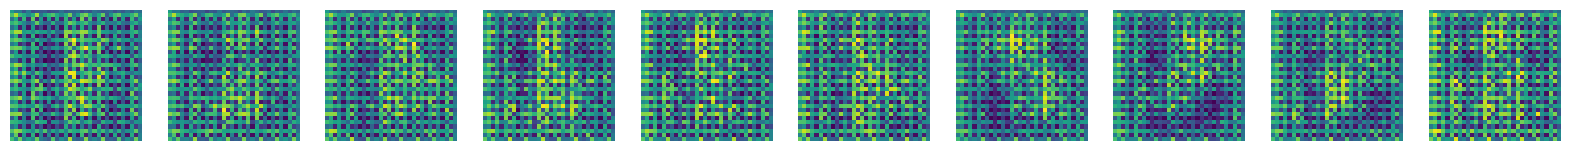

117/117 [==============================] - 40s 302ms/step - d_loss: 1.0782 - d_real_acc: 0.6025 - d_fake_acc: 0.5815 - d_acc: 0.5920 - g_loss: 1.7901 - g_acc: 0.4185
Epoch 2/100
117/117 [==============================] - ETA: 0s - d_loss: 0.9326 - d_real_acc: 0.6167 - d_fake_acc: 0.6140 - d_acc: 0.6153 - g_loss: 1.8114 - g_acc: 0.3860
Saved to ./output/output_dcgan/generated_img_001.png


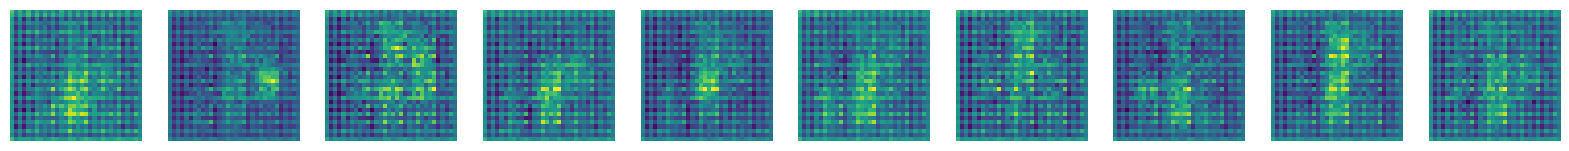

117/117 [==============================] - 28s 239ms/step - d_loss: 0.9326 - d_real_acc: 0.6167 - d_fake_acc: 0.6140 - d_acc: 0.6153 - g_loss: 1.8114 - g_acc: 0.3860
Epoch 3/100
117/117 [==============================] - ETA: 0s - d_loss: 1.1700 - d_real_acc: 0.4965 - d_fake_acc: 0.5236 - d_acc: 0.5101 - g_loss: 1.2772 - g_acc: 0.4764
Saved to ./output/output_dcgan/generated_img_002.png


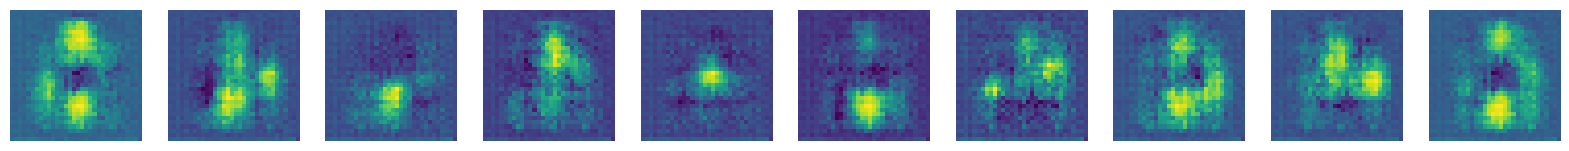

117/117 [==============================] - 28s 240ms/step - d_loss: 1.1700 - d_real_acc: 0.4965 - d_fake_acc: 0.5236 - d_acc: 0.5101 - g_loss: 1.2772 - g_acc: 0.4764
Epoch 4/100
117/117 [==============================] - ETA: 0s - d_loss: 1.0031 - d_real_acc: 0.5096 - d_fake_acc: 0.5393 - d_acc: 0.5245 - g_loss: 1.1425 - g_acc: 0.4607
Saved to ./output/output_dcgan/generated_img_003.png


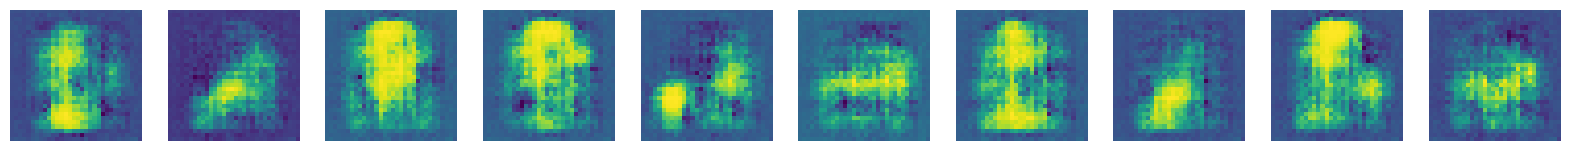

117/117 [==============================] - 28s 239ms/step - d_loss: 1.0031 - d_real_acc: 0.5096 - d_fake_acc: 0.5393 - d_acc: 0.5245 - g_loss: 1.1425 - g_acc: 0.4607
Epoch 5/100
117/117 [==============================] - ETA: 0s - d_loss: 0.8960 - d_real_acc: 0.5238 - d_fake_acc: 0.5344 - d_acc: 0.5291 - g_loss: 1.0287 - g_acc: 0.4656
Saved to ./output/output_dcgan/generated_img_004.png


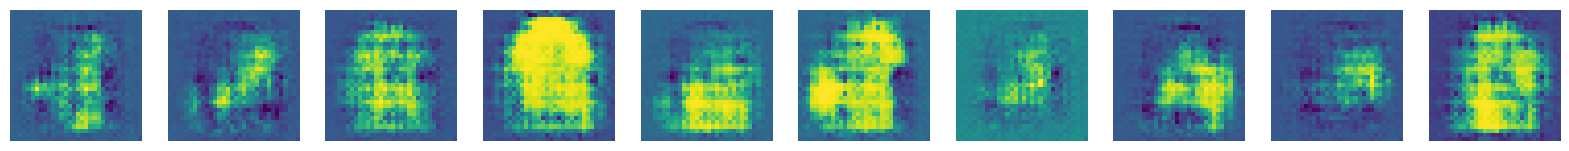

117/117 [==============================] - 28s 238ms/step - d_loss: 0.8960 - d_real_acc: 0.5238 - d_fake_acc: 0.5344 - d_acc: 0.5291 - g_loss: 1.0287 - g_acc: 0.4656
Epoch 6/100
117/117 [==============================] - ETA: 0s - d_loss: 0.8206 - d_real_acc: 0.5284 - d_fake_acc: 0.5405 - d_acc: 0.5345 - g_loss: 0.9417 - g_acc: 0.4595
Saved to ./output/output_dcgan/generated_img_005.png


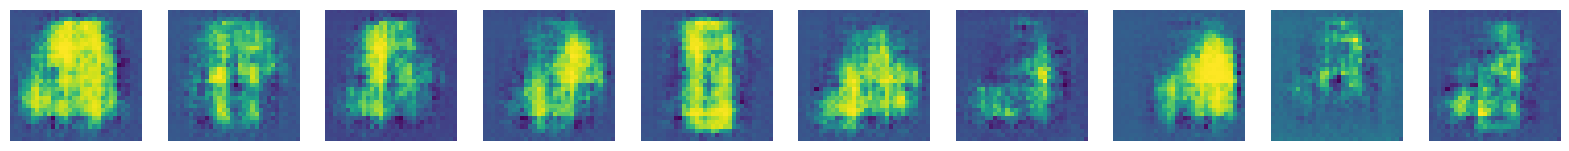

117/117 [==============================] - 28s 238ms/step - d_loss: 0.8206 - d_real_acc: 0.5284 - d_fake_acc: 0.5405 - d_acc: 0.5345 - g_loss: 0.9417 - g_acc: 0.4595
Epoch 7/100
117/117 [==============================] - ETA: 0s - d_loss: 0.7772 - d_real_acc: 0.5384 - d_fake_acc: 0.5327 - d_acc: 0.5355 - g_loss: 0.8720 - g_acc: 0.4673
Saved to ./output/output_dcgan/generated_img_006.png


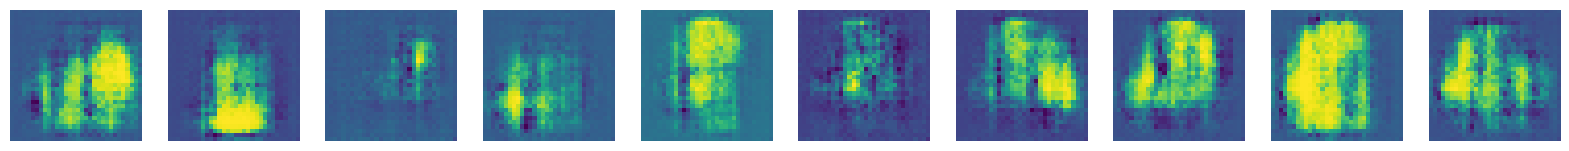

117/117 [==============================] - 28s 242ms/step - d_loss: 0.7772 - d_real_acc: 0.5384 - d_fake_acc: 0.5327 - d_acc: 0.5355 - g_loss: 0.8720 - g_acc: 0.4673
Epoch 8/100
117/117 [==============================] - ETA: 0s - d_loss: 0.7417 - d_real_acc: 0.5504 - d_fake_acc: 0.5351 - d_acc: 0.5427 - g_loss: 0.8308 - g_acc: 0.4649
Saved to ./output/output_dcgan/generated_img_007.png


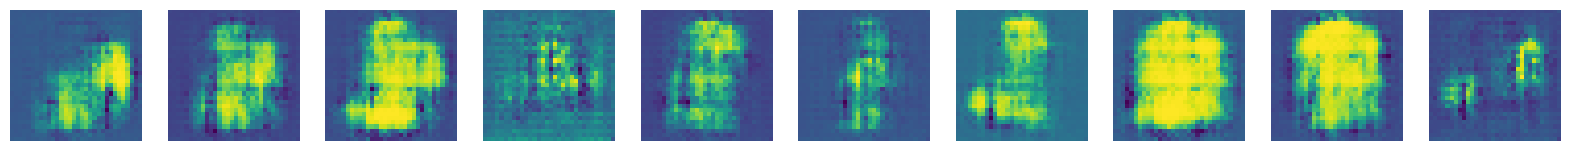

117/117 [==============================] - 28s 241ms/step - d_loss: 0.7417 - d_real_acc: 0.5504 - d_fake_acc: 0.5351 - d_acc: 0.5427 - g_loss: 0.8308 - g_acc: 0.4649
Epoch 9/100
117/117 [==============================] - ETA: 0s - d_loss: 0.7135 - d_real_acc: 0.5622 - d_fake_acc: 0.5476 - d_acc: 0.5549 - g_loss: 0.8178 - g_acc: 0.4524
Saved to ./output/output_dcgan/generated_img_008.png


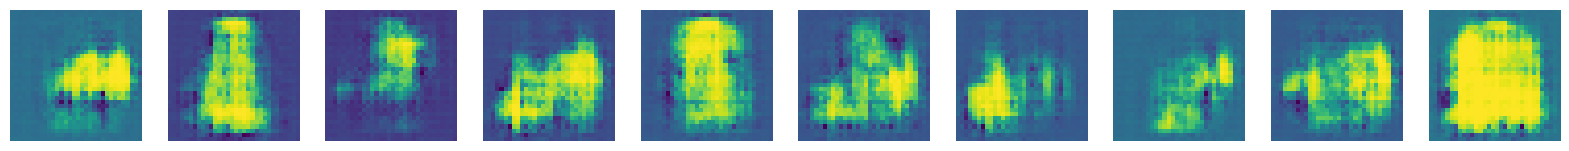

117/117 [==============================] - 29s 245ms/step - d_loss: 0.7135 - d_real_acc: 0.5622 - d_fake_acc: 0.5476 - d_acc: 0.5549 - g_loss: 0.8178 - g_acc: 0.4524
Epoch 10/100
117/117 [==============================] - ETA: 0s - d_loss: 0.6994 - d_real_acc: 0.5616 - d_fake_acc: 0.5581 - d_acc: 0.5599 - g_loss: 0.8093 - g_acc: 0.4419
Saved to ./output/output_dcgan/generated_img_009.png


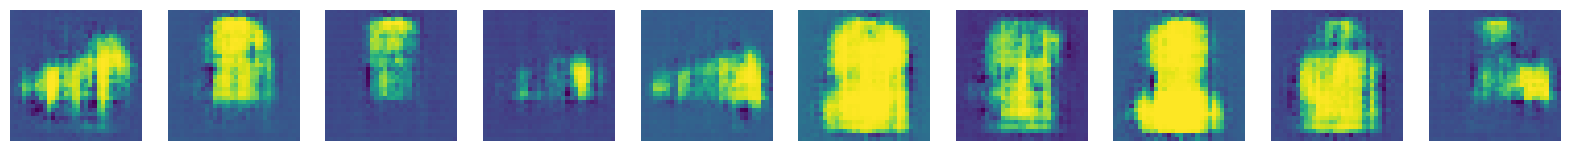

117/117 [==============================] - 28s 238ms/step - d_loss: 0.6994 - d_real_acc: 0.5616 - d_fake_acc: 0.5581 - d_acc: 0.5599 - g_loss: 0.8093 - g_acc: 0.4419
Epoch 11/100
117/117 [==============================] - ETA: 0s - d_loss: 0.6878 - d_real_acc: 0.5571 - d_fake_acc: 0.5757 - d_acc: 0.5664 - g_loss: 0.8081 - g_acc: 0.4243
Saved to ./output/output_dcgan/generated_img_010.png


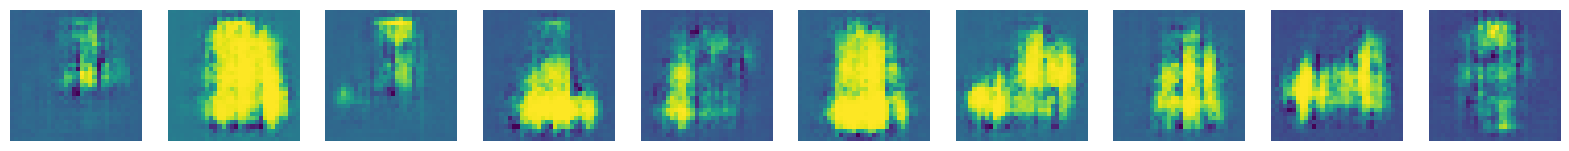

117/117 [==============================] - 28s 239ms/step - d_loss: 0.6878 - d_real_acc: 0.5571 - d_fake_acc: 0.5757 - d_acc: 0.5664 - g_loss: 0.8081 - g_acc: 0.4243
Epoch 12/100
117/117 [==============================] - ETA: 0s - d_loss: 0.6793 - d_real_acc: 0.5676 - d_fake_acc: 0.5828 - d_acc: 0.5752 - g_loss: 0.8047 - g_acc: 0.4172
Saved to ./output/output_dcgan/generated_img_011.png


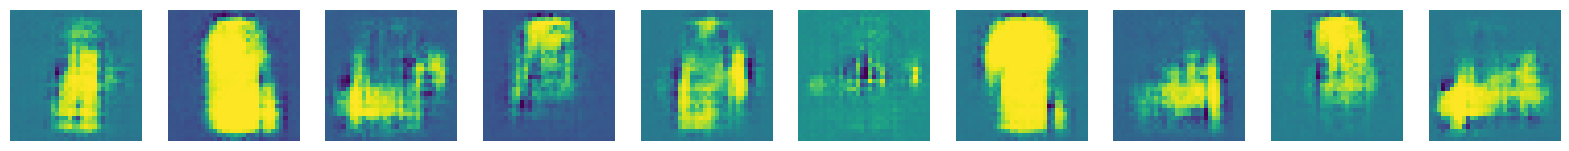

117/117 [==============================] - 28s 240ms/step - d_loss: 0.6793 - d_real_acc: 0.5676 - d_fake_acc: 0.5828 - d_acc: 0.5752 - g_loss: 0.8047 - g_acc: 0.4172
Epoch 13/100
117/117 [==============================] - ETA: 0s - d_loss: 0.6756 - d_real_acc: 0.5685 - d_fake_acc: 0.5840 - d_acc: 0.5763 - g_loss: 0.7996 - g_acc: 0.4160
Saved to ./output/output_dcgan/generated_img_012.png


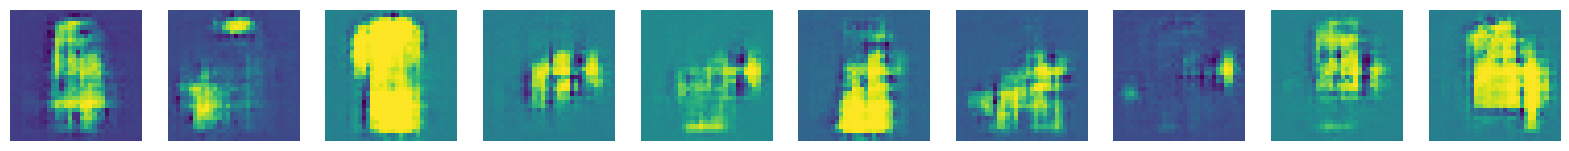

117/117 [==============================] - 28s 241ms/step - d_loss: 0.6756 - d_real_acc: 0.5685 - d_fake_acc: 0.5840 - d_acc: 0.5763 - g_loss: 0.7996 - g_acc: 0.4160
Epoch 14/100
117/117 [==============================] - ETA: 0s - d_loss: 0.6714 - d_real_acc: 0.5761 - d_fake_acc: 0.5852 - d_acc: 0.5806 - g_loss: 0.7949 - g_acc: 0.4148
Saved to ./output/output_dcgan/generated_img_013.png


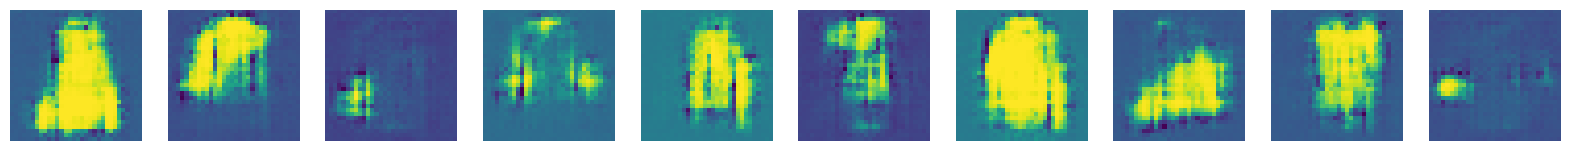

117/117 [==============================] - 28s 238ms/step - d_loss: 0.6714 - d_real_acc: 0.5761 - d_fake_acc: 0.5852 - d_acc: 0.5806 - g_loss: 0.7949 - g_acc: 0.4148
Epoch 15/100
117/117 [==============================] - ETA: 0s - d_loss: 0.6712 - d_real_acc: 0.5747 - d_fake_acc: 0.5876 - d_acc: 0.5812 - g_loss: 0.7941 - g_acc: 0.4124
Saved to ./output/output_dcgan/generated_img_014.png


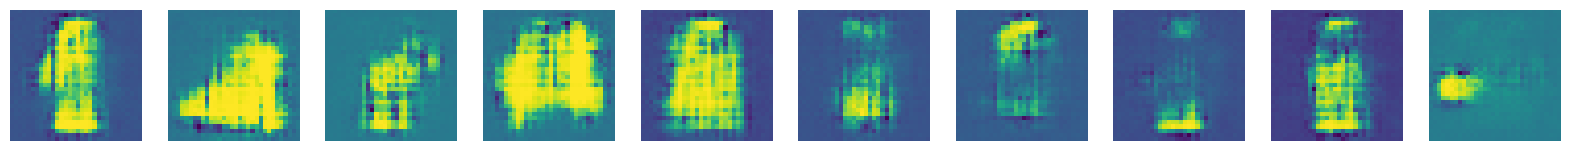

117/117 [==============================] - 28s 239ms/step - d_loss: 0.6712 - d_real_acc: 0.5747 - d_fake_acc: 0.5876 - d_acc: 0.5812 - g_loss: 0.7941 - g_acc: 0.4124
Epoch 16/100
117/117 [==============================] - ETA: 0s - d_loss: 0.6661 - d_real_acc: 0.5818 - d_fake_acc: 0.5926 - d_acc: 0.5872 - g_loss: 0.7955 - g_acc: 0.4074
Saved to ./output/output_dcgan/generated_img_015.png


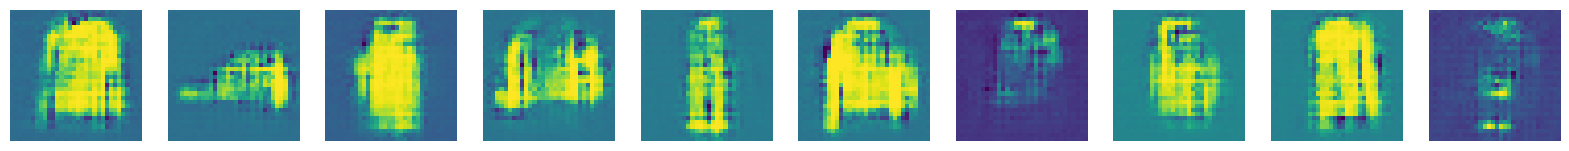

117/117 [==============================] - 28s 242ms/step - d_loss: 0.6661 - d_real_acc: 0.5818 - d_fake_acc: 0.5926 - d_acc: 0.5872 - g_loss: 0.7955 - g_acc: 0.4074
Epoch 17/100
117/117 [==============================] - ETA: 0s - d_loss: 0.6601 - d_real_acc: 0.5945 - d_fake_acc: 0.5985 - d_acc: 0.5965 - g_loss: 0.8017 - g_acc: 0.4015
Saved to ./output/output_dcgan/generated_img_016.png


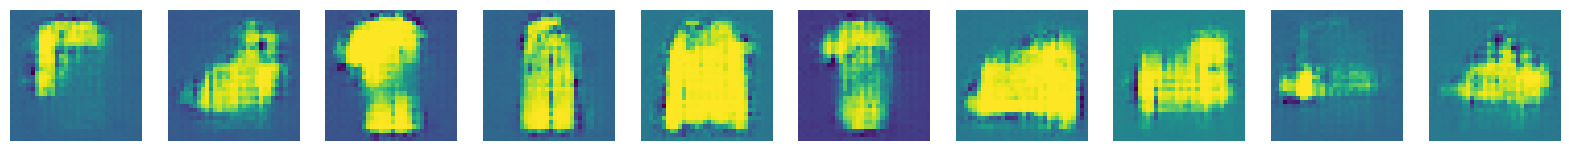

117/117 [==============================] - 28s 239ms/step - d_loss: 0.6601 - d_real_acc: 0.5945 - d_fake_acc: 0.5985 - d_acc: 0.5965 - g_loss: 0.8017 - g_acc: 0.4015
Epoch 18/100
117/117 [==============================] - ETA: 0s - d_loss: 0.6501 - d_real_acc: 0.6092 - d_fake_acc: 0.6100 - d_acc: 0.6096 - g_loss: 0.8148 - g_acc: 0.3900
Saved to ./output/output_dcgan/generated_img_017.png


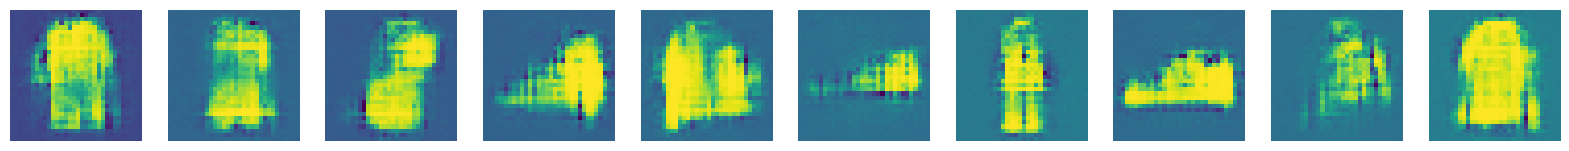

117/117 [==============================] - 28s 242ms/step - d_loss: 0.6501 - d_real_acc: 0.6092 - d_fake_acc: 0.6100 - d_acc: 0.6096 - g_loss: 0.8148 - g_acc: 0.3900
Epoch 19/100
117/117 [==============================] - ETA: 0s - d_loss: 0.6408 - d_real_acc: 0.6200 - d_fake_acc: 0.6184 - d_acc: 0.6192 - g_loss: 0.8312 - g_acc: 0.3816
Saved to ./output/output_dcgan/generated_img_018.png


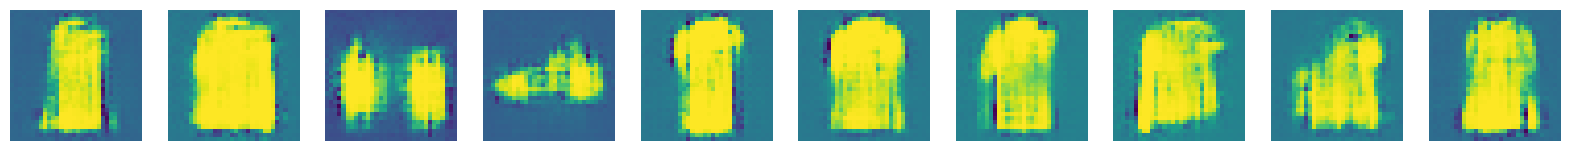

117/117 [==============================] - 28s 241ms/step - d_loss: 0.6408 - d_real_acc: 0.6200 - d_fake_acc: 0.6184 - d_acc: 0.6192 - g_loss: 0.8312 - g_acc: 0.3816
Epoch 20/100
117/117 [==============================] - ETA: 0s - d_loss: 0.6340 - d_real_acc: 0.6319 - d_fake_acc: 0.6228 - d_acc: 0.6274 - g_loss: 0.8463 - g_acc: 0.3772
Saved to ./output/output_dcgan/generated_img_019.png


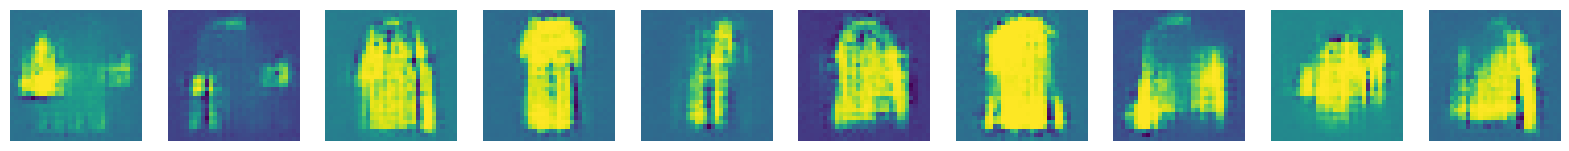

117/117 [==============================] - 28s 241ms/step - d_loss: 0.6340 - d_real_acc: 0.6319 - d_fake_acc: 0.6228 - d_acc: 0.6274 - g_loss: 0.8463 - g_acc: 0.3772
Epoch 21/100
117/117 [==============================] - ETA: 0s - d_loss: 0.6208 - d_real_acc: 0.6471 - d_fake_acc: 0.6371 - d_acc: 0.6421 - g_loss: 0.8730 - g_acc: 0.3629
Saved to ./output/output_dcgan/generated_img_020.png


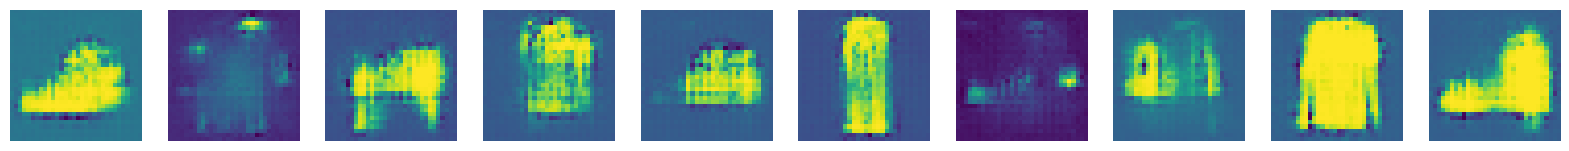

117/117 [==============================] - 28s 241ms/step - d_loss: 0.6208 - d_real_acc: 0.6471 - d_fake_acc: 0.6371 - d_acc: 0.6421 - g_loss: 0.8730 - g_acc: 0.3629
Epoch 22/100
117/117 [==============================] - ETA: 0s - d_loss: 0.6127 - d_real_acc: 0.6560 - d_fake_acc: 0.6420 - d_acc: 0.6490 - g_loss: 0.8946 - g_acc: 0.3580
Saved to ./output/output_dcgan/generated_img_021.png


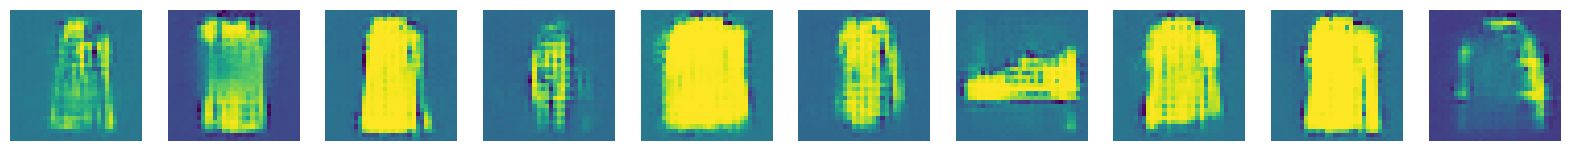

117/117 [==============================] - 28s 238ms/step - d_loss: 0.6127 - d_real_acc: 0.6560 - d_fake_acc: 0.6420 - d_acc: 0.6490 - g_loss: 0.8946 - g_acc: 0.3580
Epoch 23/100
117/117 [==============================] - ETA: 0s - d_loss: 0.6094 - d_real_acc: 0.6585 - d_fake_acc: 0.6428 - d_acc: 0.6507 - g_loss: 0.9105 - g_acc: 0.3572
Saved to ./output/output_dcgan/generated_img_022.png


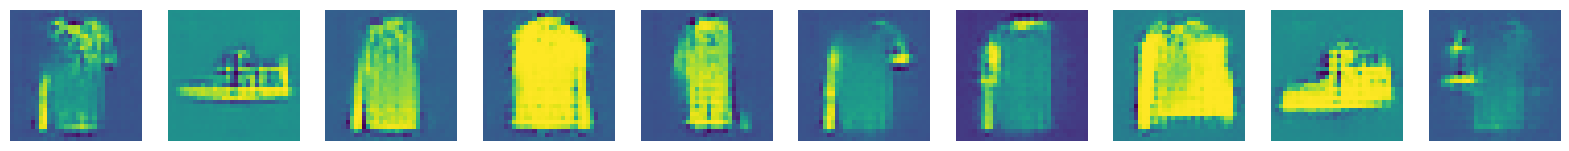

117/117 [==============================] - 28s 242ms/step - d_loss: 0.6094 - d_real_acc: 0.6585 - d_fake_acc: 0.6428 - d_acc: 0.6507 - g_loss: 0.9105 - g_acc: 0.3572
Epoch 24/100
117/117 [==============================] - ETA: 0s - d_loss: 0.6136 - d_real_acc: 0.6561 - d_fake_acc: 0.6378 - d_acc: 0.6469 - g_loss: 0.9091 - g_acc: 0.3622
Saved to ./output/output_dcgan/generated_img_023.png


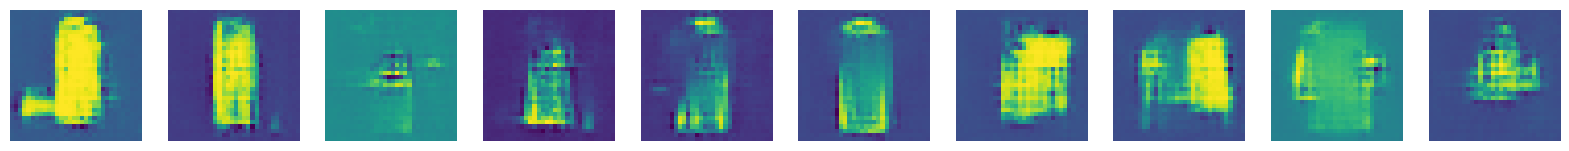

117/117 [==============================] - 28s 238ms/step - d_loss: 0.6136 - d_real_acc: 0.6561 - d_fake_acc: 0.6378 - d_acc: 0.6469 - g_loss: 0.9091 - g_acc: 0.3622
Epoch 25/100
117/117 [==============================] - ETA: 0s - d_loss: 0.6224 - d_real_acc: 0.6463 - d_fake_acc: 0.6287 - d_acc: 0.6375 - g_loss: 0.9040 - g_acc: 0.3713
Saved to ./output/output_dcgan/generated_img_024.png


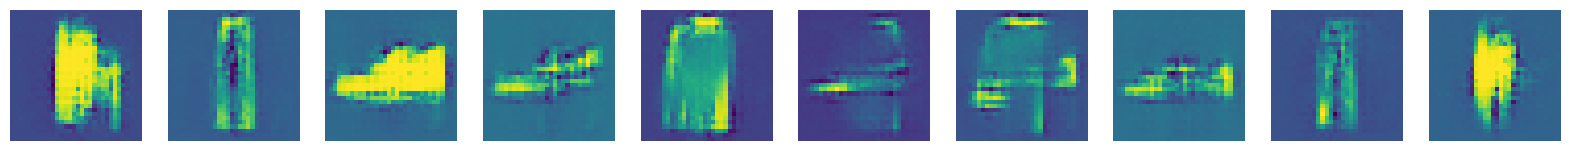

117/117 [==============================] - 28s 244ms/step - d_loss: 0.6224 - d_real_acc: 0.6463 - d_fake_acc: 0.6287 - d_acc: 0.6375 - g_loss: 0.9040 - g_acc: 0.3713
Epoch 26/100
117/117 [==============================] - ETA: 0s - d_loss: 0.6239 - d_real_acc: 0.6465 - d_fake_acc: 0.6302 - d_acc: 0.6383 - g_loss: 0.8978 - g_acc: 0.3698
Saved to ./output/output_dcgan/generated_img_025.png


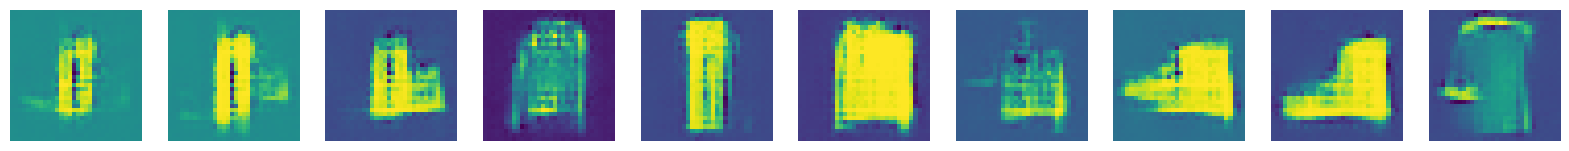

117/117 [==============================] - 28s 240ms/step - d_loss: 0.6239 - d_real_acc: 0.6465 - d_fake_acc: 0.6302 - d_acc: 0.6383 - g_loss: 0.8978 - g_acc: 0.3698
Epoch 27/100
117/117 [==============================] - ETA: 0s - d_loss: 0.6305 - d_real_acc: 0.6360 - d_fake_acc: 0.6262 - d_acc: 0.6311 - g_loss: 0.8921 - g_acc: 0.3738
Saved to ./output/output_dcgan/generated_img_026.png


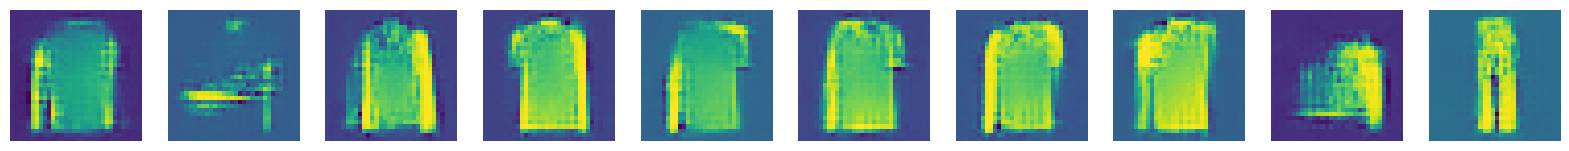

117/117 [==============================] - 28s 239ms/step - d_loss: 0.6305 - d_real_acc: 0.6360 - d_fake_acc: 0.6262 - d_acc: 0.6311 - g_loss: 0.8921 - g_acc: 0.3738
Epoch 28/100
117/117 [==============================] - ETA: 0s - d_loss: 0.6318 - d_real_acc: 0.6335 - d_fake_acc: 0.6223 - d_acc: 0.6279 - g_loss: 0.8848 - g_acc: 0.3777
Saved to ./output/output_dcgan/generated_img_027.png


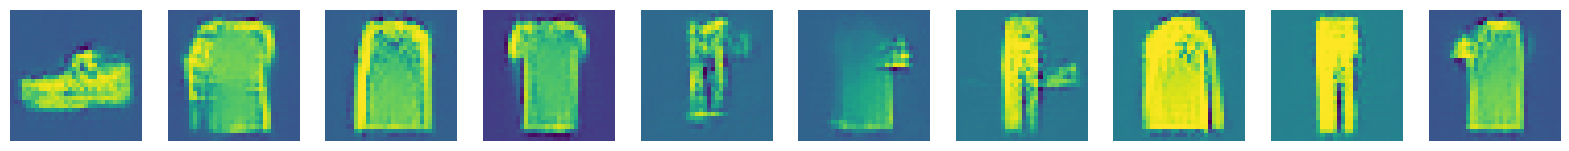

117/117 [==============================] - 28s 242ms/step - d_loss: 0.6318 - d_real_acc: 0.6335 - d_fake_acc: 0.6223 - d_acc: 0.6279 - g_loss: 0.8848 - g_acc: 0.3777
Epoch 29/100
117/117 [==============================] - ETA: 0s - d_loss: 0.6363 - d_real_acc: 0.6286 - d_fake_acc: 0.6192 - d_acc: 0.6239 - g_loss: 0.8738 - g_acc: 0.3808
Saved to ./output/output_dcgan/generated_img_028.png


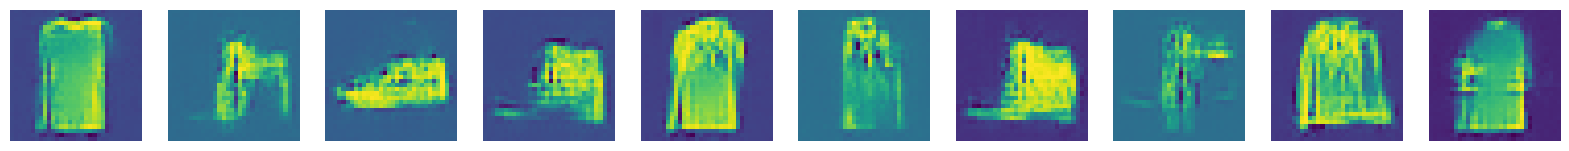

117/117 [==============================] - 28s 239ms/step - d_loss: 0.6363 - d_real_acc: 0.6286 - d_fake_acc: 0.6192 - d_acc: 0.6239 - g_loss: 0.8738 - g_acc: 0.3808
Epoch 30/100
117/117 [==============================] - ETA: 0s - d_loss: 0.6405 - d_real_acc: 0.6239 - d_fake_acc: 0.6147 - d_acc: 0.6193 - g_loss: 0.8653 - g_acc: 0.3853
Saved to ./output/output_dcgan/generated_img_029.png


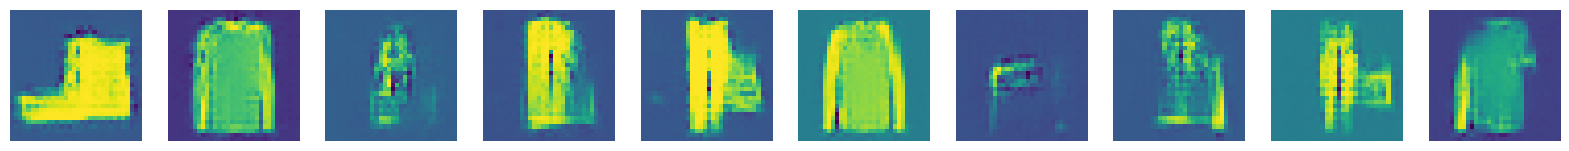

117/117 [==============================] - 28s 239ms/step - d_loss: 0.6405 - d_real_acc: 0.6239 - d_fake_acc: 0.6147 - d_acc: 0.6193 - g_loss: 0.8653 - g_acc: 0.3853
Epoch 31/100
117/117 [==============================] - ETA: 0s - d_loss: 0.6422 - d_real_acc: 0.6225 - d_fake_acc: 0.6114 - d_acc: 0.6170 - g_loss: 0.8584 - g_acc: 0.3886
Saved to ./output/output_dcgan/generated_img_030.png


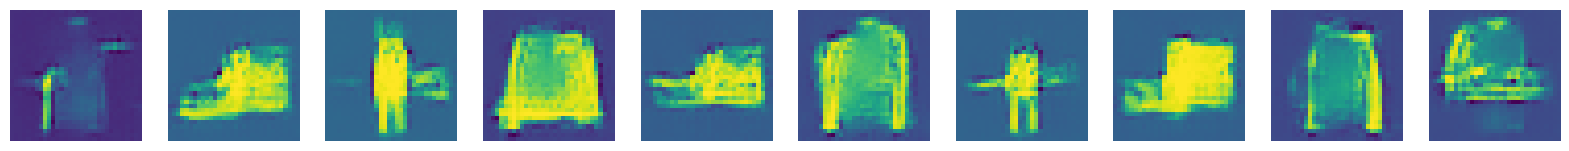

117/117 [==============================] - 28s 239ms/step - d_loss: 0.6422 - d_real_acc: 0.6225 - d_fake_acc: 0.6114 - d_acc: 0.6170 - g_loss: 0.8584 - g_acc: 0.3886
Epoch 32/100
117/117 [==============================] - ETA: 0s - d_loss: 0.6409 - d_real_acc: 0.6186 - d_fake_acc: 0.6153 - d_acc: 0.6169 - g_loss: 0.8609 - g_acc: 0.3847
Saved to ./output/output_dcgan/generated_img_031.png


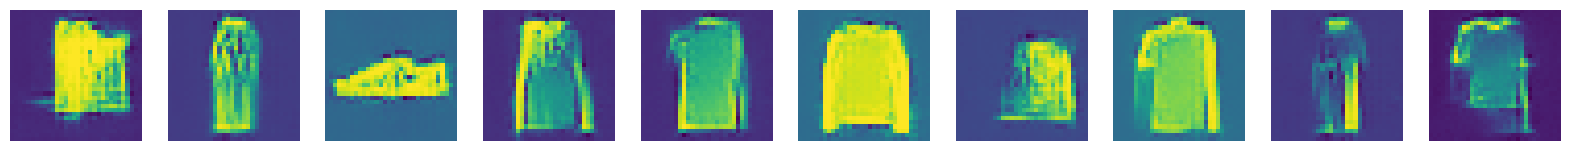

117/117 [==============================] - 28s 241ms/step - d_loss: 0.6409 - d_real_acc: 0.6186 - d_fake_acc: 0.6153 - d_acc: 0.6169 - g_loss: 0.8609 - g_acc: 0.3847
Epoch 33/100
117/117 [==============================] - ETA: 0s - d_loss: 0.6468 - d_real_acc: 0.6155 - d_fake_acc: 0.6102 - d_acc: 0.6128 - g_loss: 0.8501 - g_acc: 0.3898
Saved to ./output/output_dcgan/generated_img_032.png


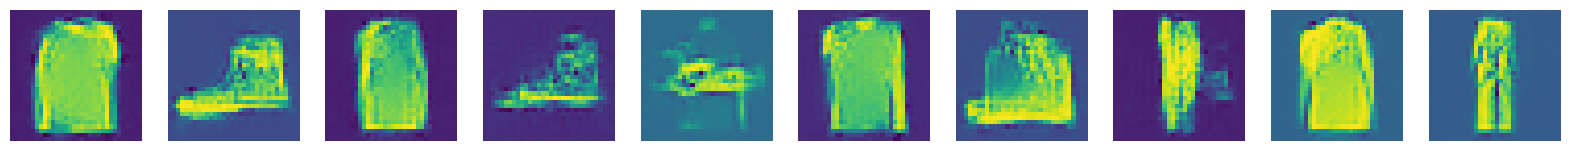

117/117 [==============================] - 28s 239ms/step - d_loss: 0.6468 - d_real_acc: 0.6155 - d_fake_acc: 0.6102 - d_acc: 0.6128 - g_loss: 0.8501 - g_acc: 0.3898
Epoch 34/100
117/117 [==============================] - ETA: 0s - d_loss: 0.6466 - d_real_acc: 0.6145 - d_fake_acc: 0.6089 - d_acc: 0.6117 - g_loss: 0.8453 - g_acc: 0.3911
Saved to ./output/output_dcgan/generated_img_033.png


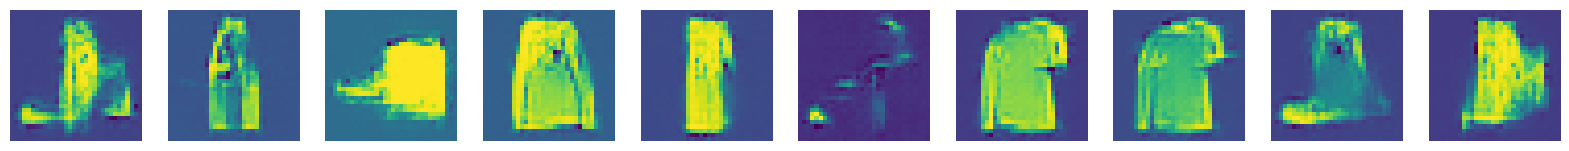

117/117 [==============================] - 28s 242ms/step - d_loss: 0.6466 - d_real_acc: 0.6145 - d_fake_acc: 0.6089 - d_acc: 0.6117 - g_loss: 0.8453 - g_acc: 0.3911
Epoch 35/100
117/117 [==============================] - ETA: 0s - d_loss: 0.6465 - d_real_acc: 0.6155 - d_fake_acc: 0.6081 - d_acc: 0.6118 - g_loss: 0.8406 - g_acc: 0.3919
Saved to ./output/output_dcgan/generated_img_034.png


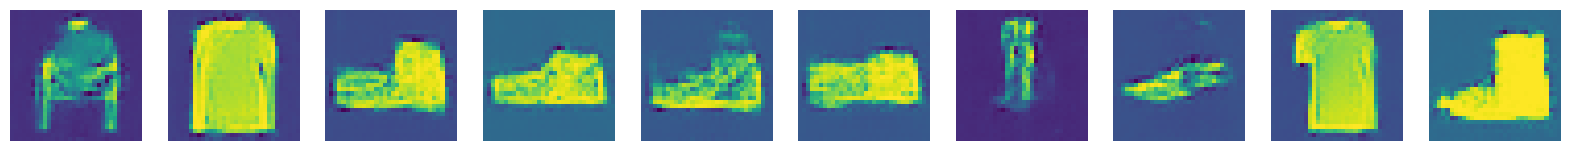

117/117 [==============================] - 28s 242ms/step - d_loss: 0.6465 - d_real_acc: 0.6155 - d_fake_acc: 0.6081 - d_acc: 0.6118 - g_loss: 0.8406 - g_acc: 0.3919
Epoch 36/100
117/117 [==============================] - ETA: 0s - d_loss: 0.6470 - d_real_acc: 0.6147 - d_fake_acc: 0.6091 - d_acc: 0.6119 - g_loss: 0.8381 - g_acc: 0.3909
Saved to ./output/output_dcgan/generated_img_035.png


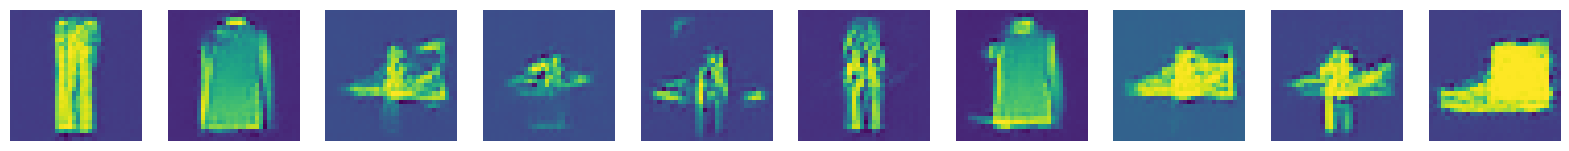

117/117 [==============================] - 28s 239ms/step - d_loss: 0.6470 - d_real_acc: 0.6147 - d_fake_acc: 0.6091 - d_acc: 0.6119 - g_loss: 0.8381 - g_acc: 0.3909
Epoch 37/100
117/117 [==============================] - ETA: 0s - d_loss: 0.6446 - d_real_acc: 0.6192 - d_fake_acc: 0.6099 - d_acc: 0.6146 - g_loss: 0.8407 - g_acc: 0.3901
Saved to ./output/output_dcgan/generated_img_036.png


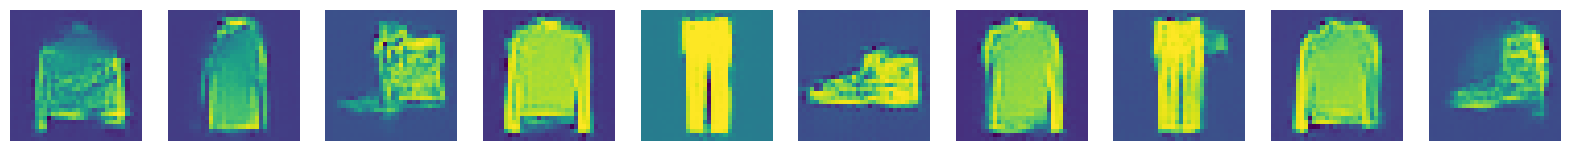

117/117 [==============================] - 28s 239ms/step - d_loss: 0.6446 - d_real_acc: 0.6192 - d_fake_acc: 0.6099 - d_acc: 0.6146 - g_loss: 0.8407 - g_acc: 0.3901
Epoch 38/100
117/117 [==============================] - ETA: 0s - d_loss: 0.6454 - d_real_acc: 0.6159 - d_fake_acc: 0.6096 - d_acc: 0.6127 - g_loss: 0.8404 - g_acc: 0.3904
Saved to ./output/output_dcgan/generated_img_037.png


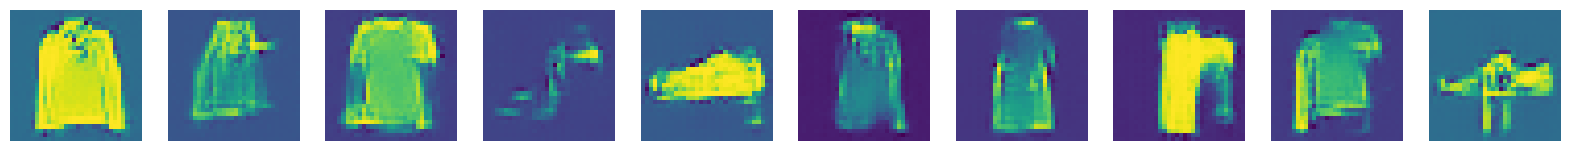

117/117 [==============================] - 28s 239ms/step - d_loss: 0.6454 - d_real_acc: 0.6159 - d_fake_acc: 0.6096 - d_acc: 0.6127 - g_loss: 0.8404 - g_acc: 0.3904
Epoch 39/100
117/117 [==============================] - ETA: 0s - d_loss: 0.6485 - d_real_acc: 0.6104 - d_fake_acc: 0.6078 - d_acc: 0.6091 - g_loss: 0.8352 - g_acc: 0.3922
Saved to ./output/output_dcgan/generated_img_038.png


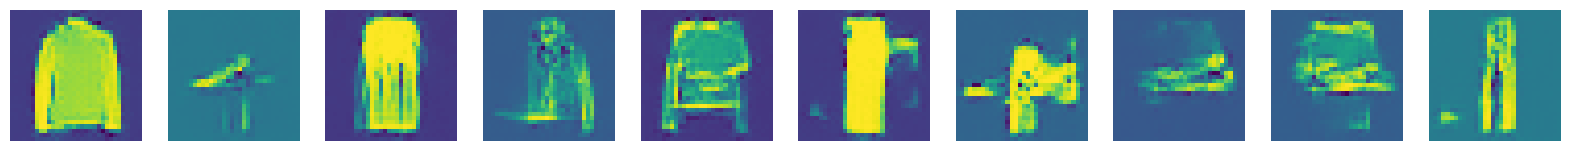

117/117 [==============================] - 28s 239ms/step - d_loss: 0.6485 - d_real_acc: 0.6104 - d_fake_acc: 0.6078 - d_acc: 0.6091 - g_loss: 0.8352 - g_acc: 0.3922
Epoch 40/100
117/117 [==============================] - ETA: 0s - d_loss: 0.6461 - d_real_acc: 0.6141 - d_fake_acc: 0.6095 - d_acc: 0.6118 - g_loss: 0.8356 - g_acc: 0.3905
Saved to ./output/output_dcgan/generated_img_039.png


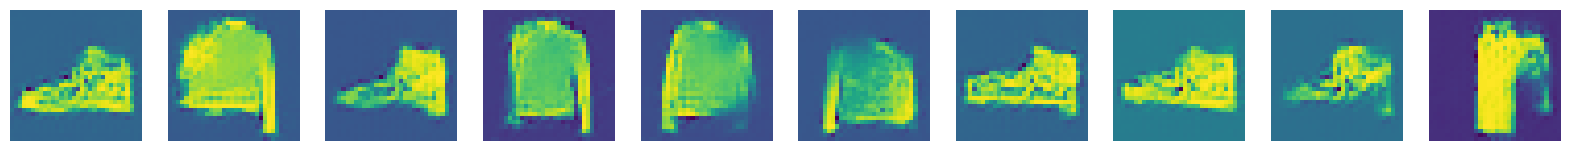

117/117 [==============================] - 28s 239ms/step - d_loss: 0.6461 - d_real_acc: 0.6141 - d_fake_acc: 0.6095 - d_acc: 0.6118 - g_loss: 0.8356 - g_acc: 0.3905
Epoch 41/100
117/117 [==============================] - ETA: 0s - d_loss: 0.6441 - d_real_acc: 0.6159 - d_fake_acc: 0.6109 - d_acc: 0.6134 - g_loss: 0.8409 - g_acc: 0.3891
Saved to ./output/output_dcgan/generated_img_040.png


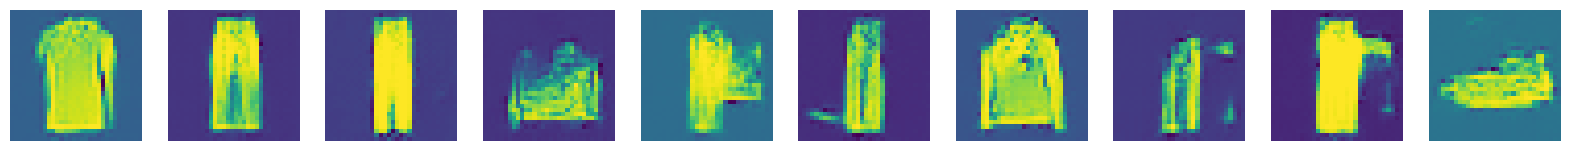

117/117 [==============================] - 29s 245ms/step - d_loss: 0.6441 - d_real_acc: 0.6159 - d_fake_acc: 0.6109 - d_acc: 0.6134 - g_loss: 0.8409 - g_acc: 0.3891
Epoch 42/100
117/117 [==============================] - ETA: 0s - d_loss: 0.6464 - d_real_acc: 0.6126 - d_fake_acc: 0.6113 - d_acc: 0.6120 - g_loss: 0.8387 - g_acc: 0.3887
Saved to ./output/output_dcgan/generated_img_041.png


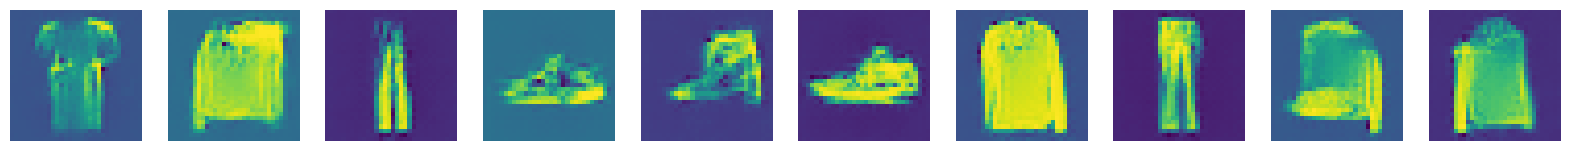

117/117 [==============================] - 28s 241ms/step - d_loss: 0.6464 - d_real_acc: 0.6126 - d_fake_acc: 0.6113 - d_acc: 0.6120 - g_loss: 0.8387 - g_acc: 0.3887
Epoch 43/100
117/117 [==============================] - ETA: 0s - d_loss: 0.6436 - d_real_acc: 0.6191 - d_fake_acc: 0.6090 - d_acc: 0.6141 - g_loss: 0.8408 - g_acc: 0.3910
Saved to ./output/output_dcgan/generated_img_042.png


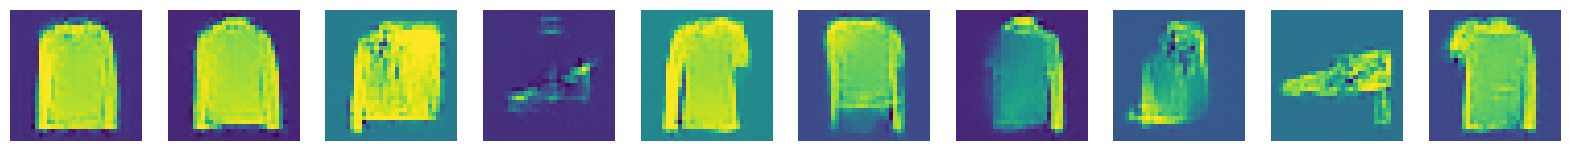

117/117 [==============================] - 28s 237ms/step - d_loss: 0.6436 - d_real_acc: 0.6191 - d_fake_acc: 0.6090 - d_acc: 0.6141 - g_loss: 0.8408 - g_acc: 0.3910
Epoch 44/100
117/117 [==============================] - ETA: 0s - d_loss: 0.6425 - d_real_acc: 0.6201 - d_fake_acc: 0.6109 - d_acc: 0.6155 - g_loss: 0.8453 - g_acc: 0.3891
Saved to ./output/output_dcgan/generated_img_043.png


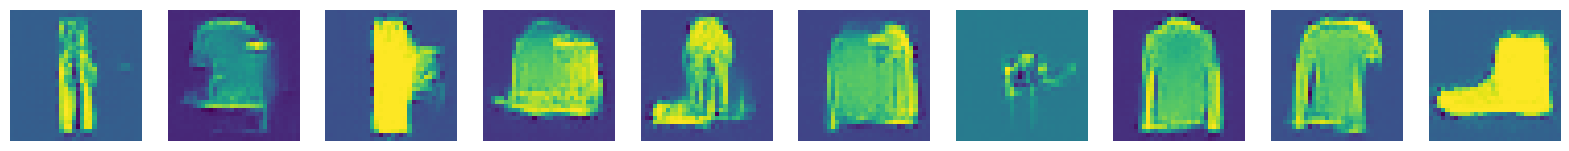

117/117 [==============================] - 28s 239ms/step - d_loss: 0.6425 - d_real_acc: 0.6201 - d_fake_acc: 0.6109 - d_acc: 0.6155 - g_loss: 0.8453 - g_acc: 0.3891
Epoch 45/100
117/117 [==============================] - ETA: 0s - d_loss: 0.6461 - d_real_acc: 0.6159 - d_fake_acc: 0.6085 - d_acc: 0.6122 - g_loss: 0.8432 - g_acc: 0.3915
Saved to ./output/output_dcgan/generated_img_044.png


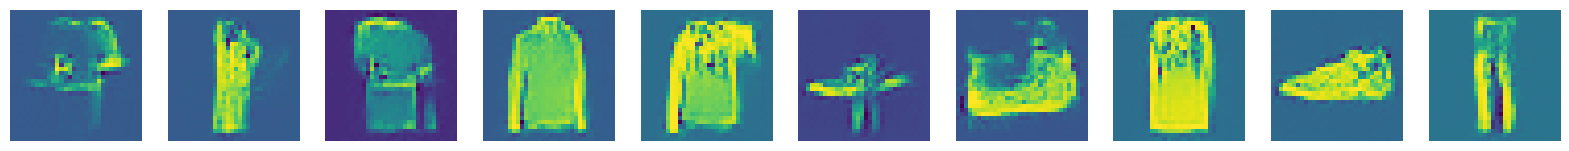

117/117 [==============================] - 28s 242ms/step - d_loss: 0.6461 - d_real_acc: 0.6159 - d_fake_acc: 0.6085 - d_acc: 0.6122 - g_loss: 0.8432 - g_acc: 0.3915
Epoch 46/100
117/117 [==============================] - ETA: 0s - d_loss: 0.6402 - d_real_acc: 0.6195 - d_fake_acc: 0.6155 - d_acc: 0.6175 - g_loss: 0.8505 - g_acc: 0.3845
Saved to ./output/output_dcgan/generated_img_045.png


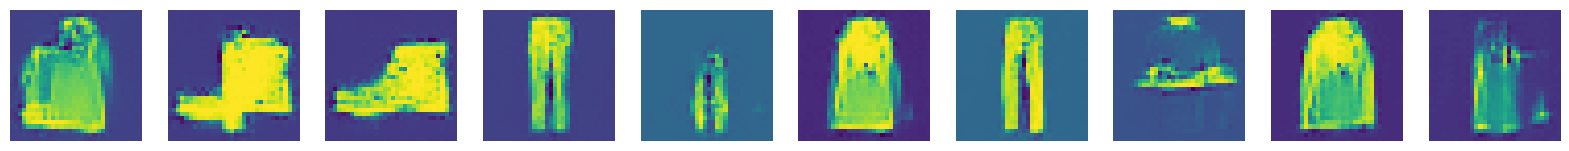

117/117 [==============================] - 28s 239ms/step - d_loss: 0.6402 - d_real_acc: 0.6195 - d_fake_acc: 0.6155 - d_acc: 0.6175 - g_loss: 0.8505 - g_acc: 0.3845
Epoch 47/100
117/117 [==============================] - ETA: 0s - d_loss: 0.6423 - d_real_acc: 0.6189 - d_fake_acc: 0.6142 - d_acc: 0.6165 - g_loss: 0.8459 - g_acc: 0.3858
Saved to ./output/output_dcgan/generated_img_046.png


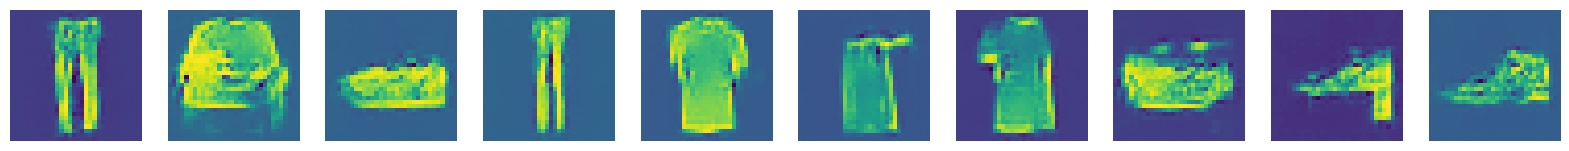

117/117 [==============================] - 28s 240ms/step - d_loss: 0.6423 - d_real_acc: 0.6189 - d_fake_acc: 0.6142 - d_acc: 0.6165 - g_loss: 0.8459 - g_acc: 0.3858
Epoch 48/100
117/117 [==============================] - ETA: 0s - d_loss: 0.6402 - d_real_acc: 0.6209 - d_fake_acc: 0.6168 - d_acc: 0.6189 - g_loss: 0.8522 - g_acc: 0.3832
Saved to ./output/output_dcgan/generated_img_047.png


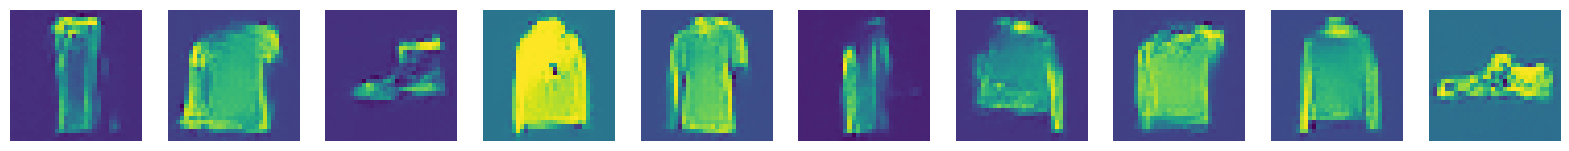

117/117 [==============================] - 29s 244ms/step - d_loss: 0.6402 - d_real_acc: 0.6209 - d_fake_acc: 0.6168 - d_acc: 0.6189 - g_loss: 0.8522 - g_acc: 0.3832
Epoch 49/100
117/117 [==============================] - ETA: 0s - d_loss: 0.6440 - d_real_acc: 0.6142 - d_fake_acc: 0.6113 - d_acc: 0.6128 - g_loss: 0.8474 - g_acc: 0.3887
Saved to ./output/output_dcgan/generated_img_048.png


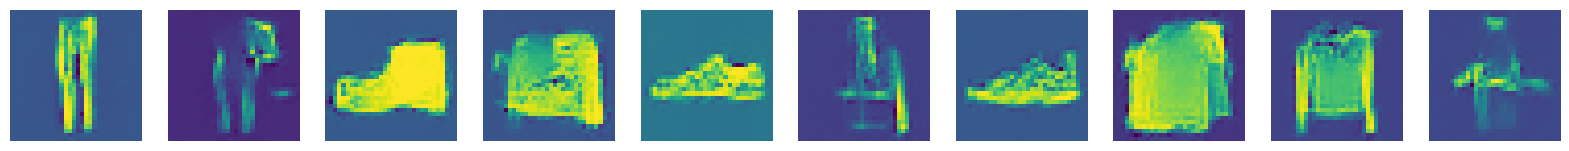

117/117 [==============================] - 28s 242ms/step - d_loss: 0.6440 - d_real_acc: 0.6142 - d_fake_acc: 0.6113 - d_acc: 0.6128 - g_loss: 0.8474 - g_acc: 0.3887
Epoch 50/100
117/117 [==============================] - ETA: 0s - d_loss: 0.6436 - d_real_acc: 0.6192 - d_fake_acc: 0.6126 - d_acc: 0.6159 - g_loss: 0.8485 - g_acc: 0.3874
Saved to ./output/output_dcgan/generated_img_049.png


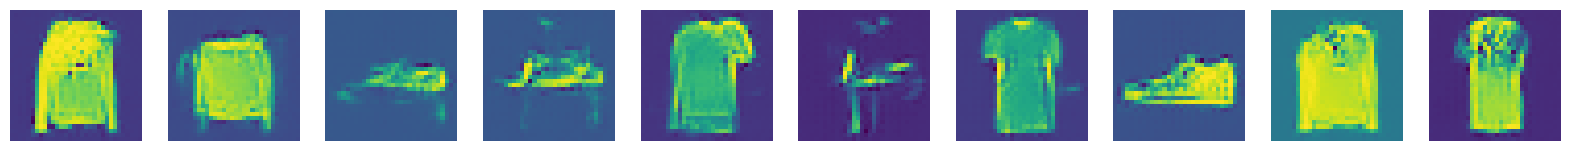

117/117 [==============================] - 28s 238ms/step - d_loss: 0.6436 - d_real_acc: 0.6192 - d_fake_acc: 0.6126 - d_acc: 0.6159 - g_loss: 0.8485 - g_acc: 0.3874
Epoch 51/100
117/117 [==============================] - ETA: 0s - d_loss: 0.6406 - d_real_acc: 0.6204 - d_fake_acc: 0.6169 - d_acc: 0.6186 - g_loss: 0.8526 - g_acc: 0.3831
Saved to ./output/output_dcgan/generated_img_050.png


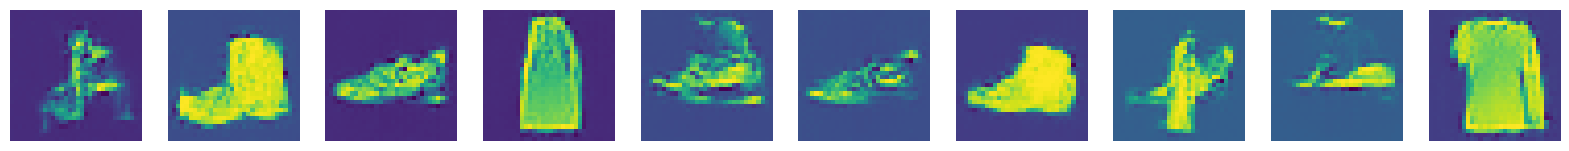

117/117 [==============================] - 28s 242ms/step - d_loss: 0.6406 - d_real_acc: 0.6204 - d_fake_acc: 0.6169 - d_acc: 0.6186 - g_loss: 0.8526 - g_acc: 0.3831
Epoch 52/100
117/117 [==============================] - ETA: 0s - d_loss: 0.6239 - d_real_acc: 0.6414 - d_fake_acc: 0.6300 - d_acc: 0.6357 - g_loss: 0.8765 - g_acc: 0.3700
Saved to ./output/output_dcgan/generated_img_051.png


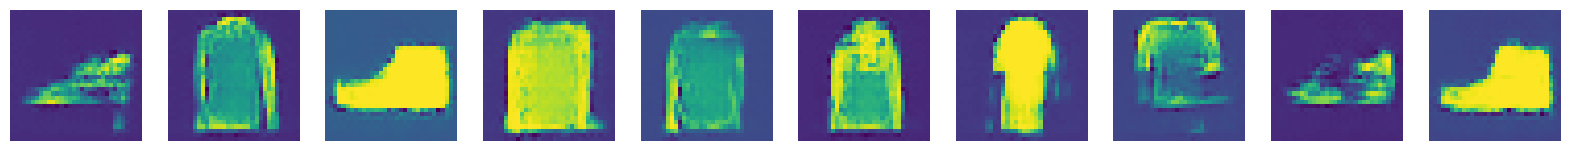

117/117 [==============================] - 28s 241ms/step - d_loss: 0.6239 - d_real_acc: 0.6414 - d_fake_acc: 0.6300 - d_acc: 0.6357 - g_loss: 0.8765 - g_acc: 0.3700
Epoch 53/100
117/117 [==============================] - ETA: 0s - d_loss: 0.6154 - d_real_acc: 0.6471 - d_fake_acc: 0.6390 - d_acc: 0.6430 - g_loss: 0.9007 - g_acc: 0.3610
Saved to ./output/output_dcgan/generated_img_052.png


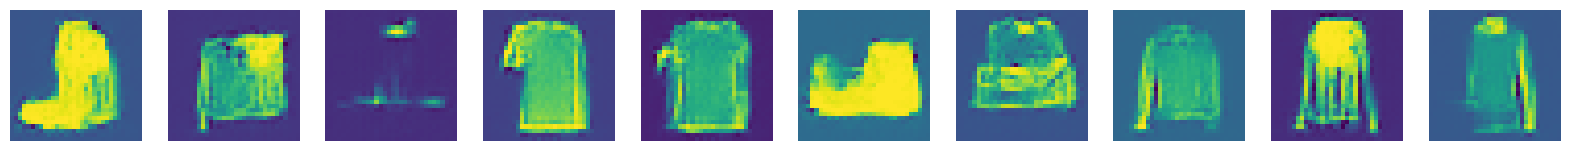

117/117 [==============================] - 28s 241ms/step - d_loss: 0.6154 - d_real_acc: 0.6471 - d_fake_acc: 0.6390 - d_acc: 0.6430 - g_loss: 0.9007 - g_acc: 0.3610
Epoch 54/100
117/117 [==============================] - ETA: 0s - d_loss: 0.6325 - d_real_acc: 0.6289 - d_fake_acc: 0.6259 - d_acc: 0.6274 - g_loss: 0.8828 - g_acc: 0.3741
Saved to ./output/output_dcgan/generated_img_053.png


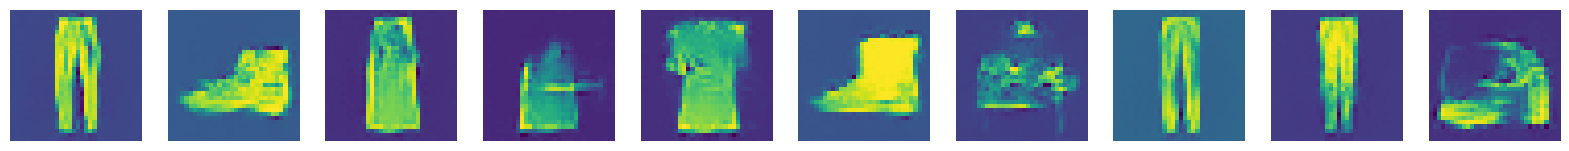

117/117 [==============================] - 28s 241ms/step - d_loss: 0.6325 - d_real_acc: 0.6289 - d_fake_acc: 0.6259 - d_acc: 0.6274 - g_loss: 0.8828 - g_acc: 0.3741
Epoch 55/100
117/117 [==============================] - ETA: 0s - d_loss: 0.6410 - d_real_acc: 0.6198 - d_fake_acc: 0.6187 - d_acc: 0.6193 - g_loss: 0.8670 - g_acc: 0.3813
Saved to ./output/output_dcgan/generated_img_054.png


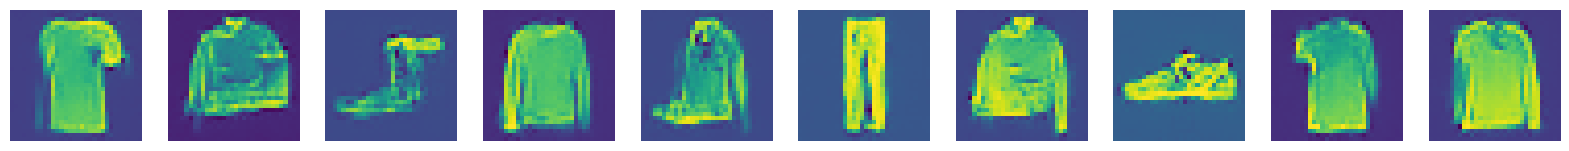

117/117 [==============================] - 28s 239ms/step - d_loss: 0.6410 - d_real_acc: 0.6198 - d_fake_acc: 0.6187 - d_acc: 0.6193 - g_loss: 0.8670 - g_acc: 0.3813
Epoch 56/100
117/117 [==============================] - ETA: 0s - d_loss: 0.6460 - d_real_acc: 0.6138 - d_fake_acc: 0.6112 - d_acc: 0.6125 - g_loss: 0.8539 - g_acc: 0.3888
Saved to ./output/output_dcgan/generated_img_055.png


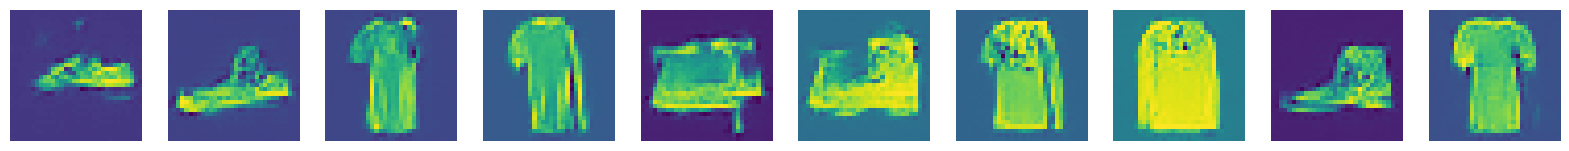

117/117 [==============================] - 28s 242ms/step - d_loss: 0.6460 - d_real_acc: 0.6138 - d_fake_acc: 0.6112 - d_acc: 0.6125 - g_loss: 0.8539 - g_acc: 0.3888
Epoch 57/100
117/117 [==============================] - ETA: 0s - d_loss: 0.6441 - d_real_acc: 0.6174 - d_fake_acc: 0.6133 - d_acc: 0.6153 - g_loss: 0.8522 - g_acc: 0.3867
Saved to ./output/output_dcgan/generated_img_056.png


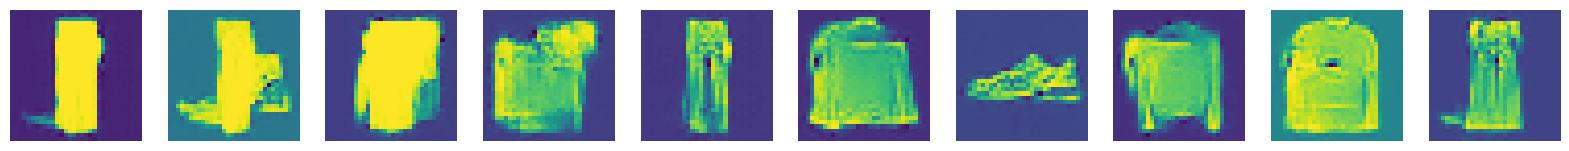

117/117 [==============================] - 28s 239ms/step - d_loss: 0.6441 - d_real_acc: 0.6174 - d_fake_acc: 0.6133 - d_acc: 0.6153 - g_loss: 0.8522 - g_acc: 0.3867
Epoch 58/100
117/117 [==============================] - ETA: 0s - d_loss: 0.6449 - d_real_acc: 0.6174 - d_fake_acc: 0.6132 - d_acc: 0.6153 - g_loss: 0.8508 - g_acc: 0.3868
Saved to ./output/output_dcgan/generated_img_057.png


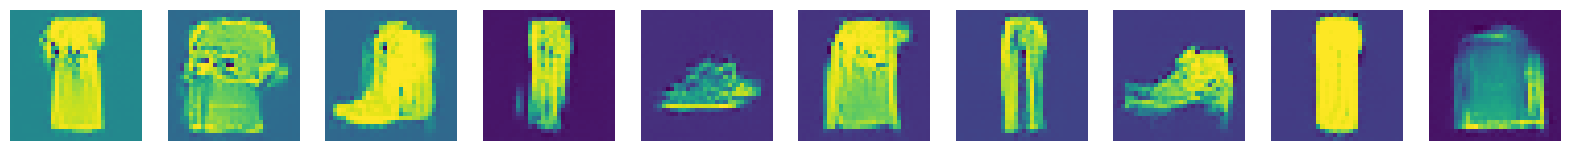

117/117 [==============================] - 28s 242ms/step - d_loss: 0.6449 - d_real_acc: 0.6174 - d_fake_acc: 0.6132 - d_acc: 0.6153 - g_loss: 0.8508 - g_acc: 0.3868
Epoch 59/100
117/117 [==============================] - ETA: 0s - d_loss: 0.6466 - d_real_acc: 0.6127 - d_fake_acc: 0.6103 - d_acc: 0.6115 - g_loss: 0.8457 - g_acc: 0.3897
Saved to ./output/output_dcgan/generated_img_058.png


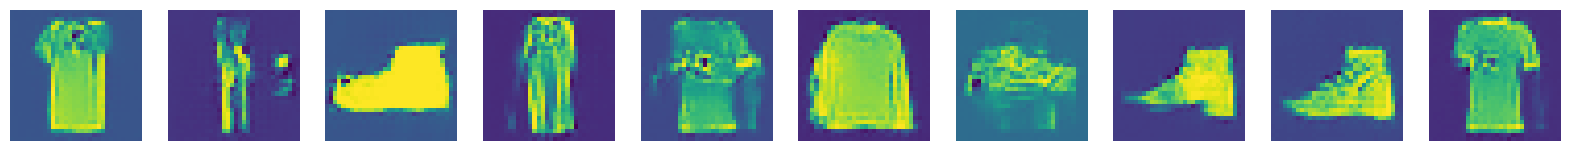

117/117 [==============================] - 28s 239ms/step - d_loss: 0.6466 - d_real_acc: 0.6127 - d_fake_acc: 0.6103 - d_acc: 0.6115 - g_loss: 0.8457 - g_acc: 0.3897
Epoch 60/100
117/117 [==============================] - ETA: 0s - d_loss: 0.6476 - d_real_acc: 0.6123 - d_fake_acc: 0.6080 - d_acc: 0.6102 - g_loss: 0.8398 - g_acc: 0.3920
Saved to ./output/output_dcgan/generated_img_059.png


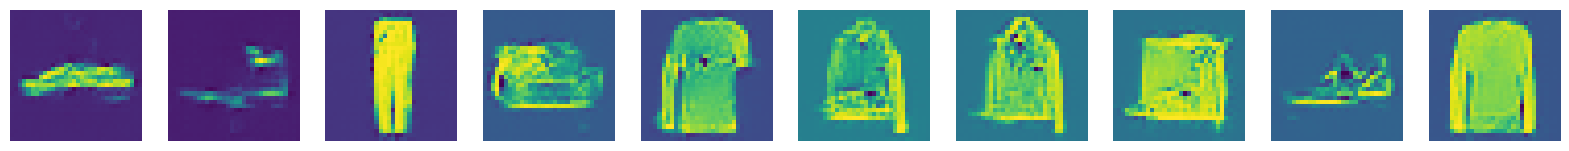

117/117 [==============================] - 28s 239ms/step - d_loss: 0.6476 - d_real_acc: 0.6123 - d_fake_acc: 0.6080 - d_acc: 0.6102 - g_loss: 0.8398 - g_acc: 0.3920
Epoch 61/100
117/117 [==============================] - ETA: 0s - d_loss: 0.6476 - d_real_acc: 0.6102 - d_fake_acc: 0.6081 - d_acc: 0.6092 - g_loss: 0.8401 - g_acc: 0.3919
Saved to ./output/output_dcgan/generated_img_060.png


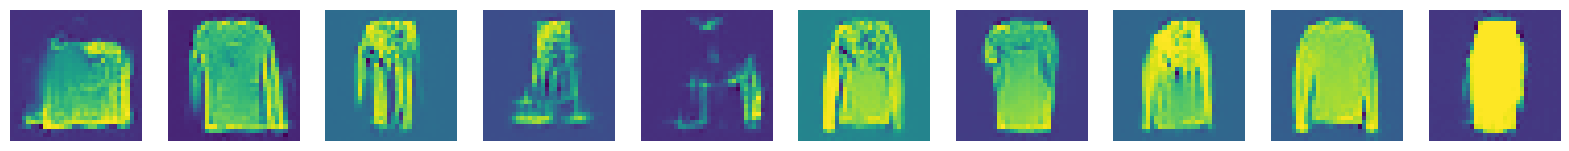

117/117 [==============================] - 28s 239ms/step - d_loss: 0.6476 - d_real_acc: 0.6102 - d_fake_acc: 0.6081 - d_acc: 0.6092 - g_loss: 0.8401 - g_acc: 0.3919
Epoch 62/100
117/117 [==============================] - ETA: 0s - d_loss: 0.6461 - d_real_acc: 0.6138 - d_fake_acc: 0.6120 - d_acc: 0.6129 - g_loss: 0.8426 - g_acc: 0.3880
Saved to ./output/output_dcgan/generated_img_061.png


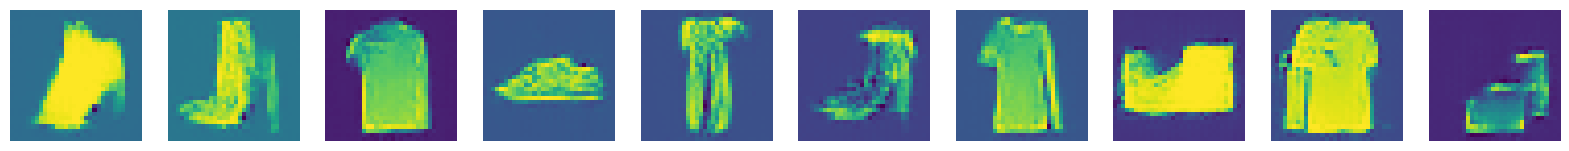

117/117 [==============================] - 28s 240ms/step - d_loss: 0.6461 - d_real_acc: 0.6138 - d_fake_acc: 0.6120 - d_acc: 0.6129 - g_loss: 0.8426 - g_acc: 0.3880
Epoch 63/100
117/117 [==============================] - ETA: 0s - d_loss: 0.6455 - d_real_acc: 0.6150 - d_fake_acc: 0.6105 - d_acc: 0.6128 - g_loss: 0.8407 - g_acc: 0.3895
Saved to ./output/output_dcgan/generated_img_062.png


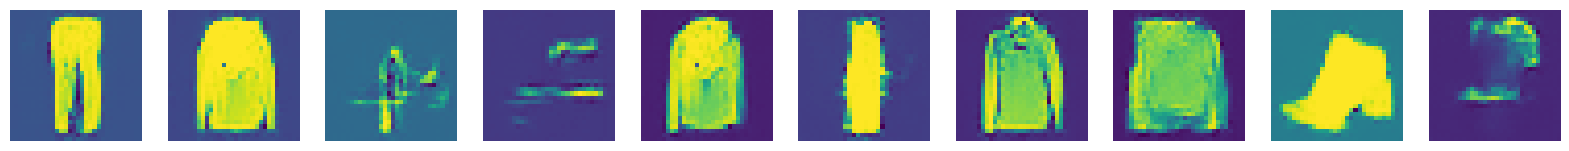

117/117 [==============================] - 28s 241ms/step - d_loss: 0.6455 - d_real_acc: 0.6150 - d_fake_acc: 0.6105 - d_acc: 0.6128 - g_loss: 0.8407 - g_acc: 0.3895
Epoch 64/100
117/117 [==============================] - ETA: 0s - d_loss: 0.6483 - d_real_acc: 0.6128 - d_fake_acc: 0.6063 - d_acc: 0.6096 - g_loss: 0.8370 - g_acc: 0.3937
Saved to ./output/output_dcgan/generated_img_063.png


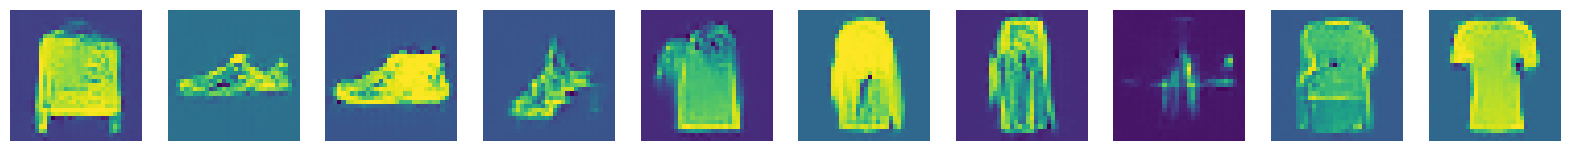

117/117 [==============================] - 29s 244ms/step - d_loss: 0.6483 - d_real_acc: 0.6128 - d_fake_acc: 0.6063 - d_acc: 0.6096 - g_loss: 0.8370 - g_acc: 0.3937
Epoch 65/100
117/117 [==============================] - ETA: 0s - d_loss: 0.6496 - d_real_acc: 0.6111 - d_fake_acc: 0.6062 - d_acc: 0.6086 - g_loss: 0.8332 - g_acc: 0.3938
Saved to ./output/output_dcgan/generated_img_064.png


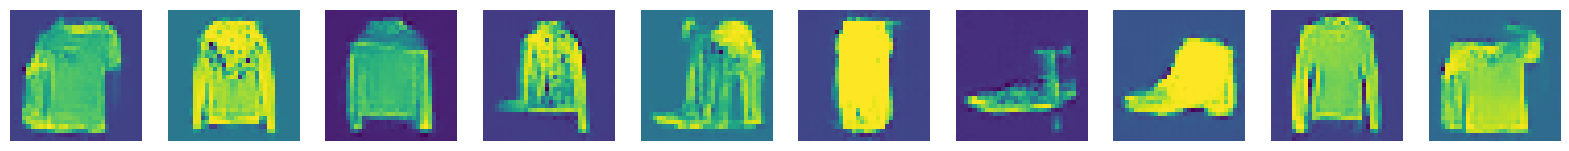

117/117 [==============================] - 28s 238ms/step - d_loss: 0.6496 - d_real_acc: 0.6111 - d_fake_acc: 0.6062 - d_acc: 0.6086 - g_loss: 0.8332 - g_acc: 0.3938
Epoch 66/100
117/117 [==============================] - ETA: 0s - d_loss: 0.6505 - d_real_acc: 0.6066 - d_fake_acc: 0.6074 - d_acc: 0.6070 - g_loss: 0.8299 - g_acc: 0.3926
Saved to ./output/output_dcgan/generated_img_065.png


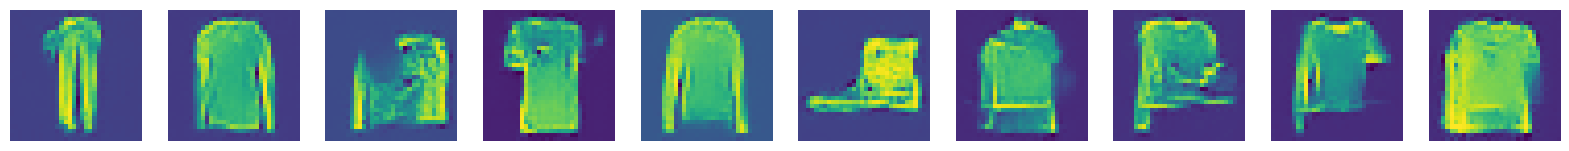

117/117 [==============================] - 28s 239ms/step - d_loss: 0.6505 - d_real_acc: 0.6066 - d_fake_acc: 0.6074 - d_acc: 0.6070 - g_loss: 0.8299 - g_acc: 0.3926
Epoch 67/100
117/117 [==============================] - ETA: 0s - d_loss: 0.6527 - d_real_acc: 0.6099 - d_fake_acc: 0.6018 - d_acc: 0.6059 - g_loss: 0.8257 - g_acc: 0.3982
Saved to ./output/output_dcgan/generated_img_066.png


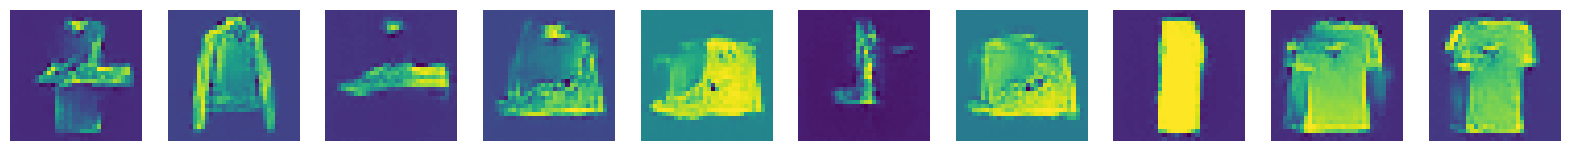

117/117 [==============================] - 29s 243ms/step - d_loss: 0.6527 - d_real_acc: 0.6099 - d_fake_acc: 0.6018 - d_acc: 0.6059 - g_loss: 0.8257 - g_acc: 0.3982
Epoch 68/100
117/117 [==============================] - ETA: 0s - d_loss: 0.6475 - d_real_acc: 0.6107 - d_fake_acc: 0.6116 - d_acc: 0.6111 - g_loss: 0.8354 - g_acc: 0.3884
Saved to ./output/output_dcgan/generated_img_067.png


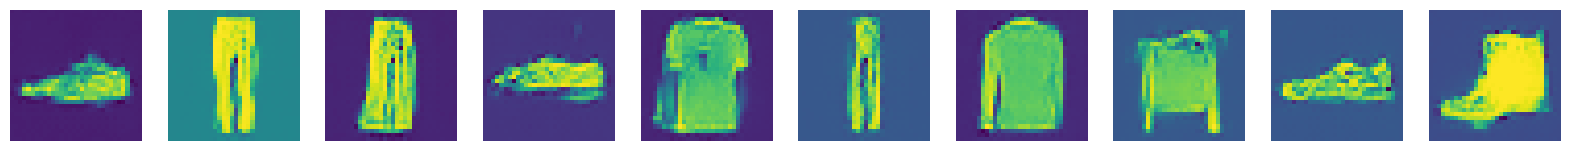

117/117 [==============================] - 28s 240ms/step - d_loss: 0.6475 - d_real_acc: 0.6107 - d_fake_acc: 0.6116 - d_acc: 0.6111 - g_loss: 0.8354 - g_acc: 0.3884
Epoch 69/100
117/117 [==============================] - ETA: 0s - d_loss: 0.6493 - d_real_acc: 0.6119 - d_fake_acc: 0.6063 - d_acc: 0.6091 - g_loss: 0.8301 - g_acc: 0.3937
Saved to ./output/output_dcgan/generated_img_068.png


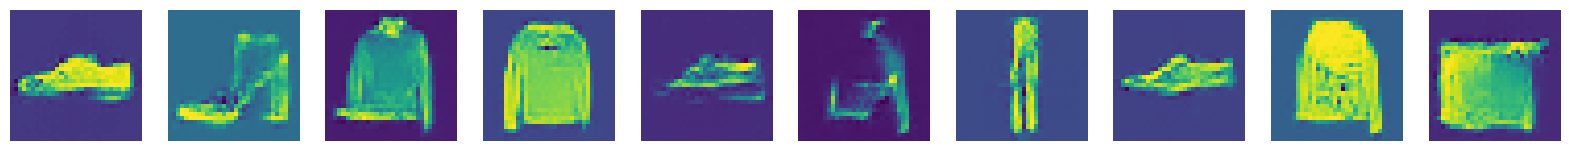

117/117 [==============================] - 28s 240ms/step - d_loss: 0.6493 - d_real_acc: 0.6119 - d_fake_acc: 0.6063 - d_acc: 0.6091 - g_loss: 0.8301 - g_acc: 0.3937
Epoch 70/100
117/117 [==============================] - ETA: 0s - d_loss: 0.6503 - d_real_acc: 0.6104 - d_fake_acc: 0.6063 - d_acc: 0.6083 - g_loss: 0.8290 - g_acc: 0.3937
Saved to ./output/output_dcgan/generated_img_069.png


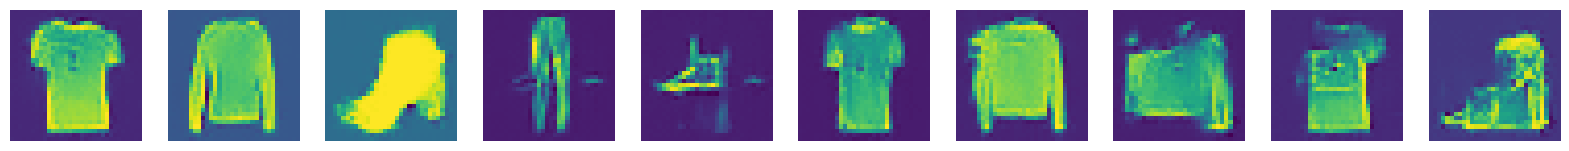

117/117 [==============================] - 28s 239ms/step - d_loss: 0.6503 - d_real_acc: 0.6104 - d_fake_acc: 0.6063 - d_acc: 0.6083 - g_loss: 0.8290 - g_acc: 0.3937
Epoch 71/100
117/117 [==============================] - ETA: 0s - d_loss: 0.6490 - d_real_acc: 0.6111 - d_fake_acc: 0.6061 - d_acc: 0.6086 - g_loss: 0.8293 - g_acc: 0.3939
Saved to ./output/output_dcgan/generated_img_070.png


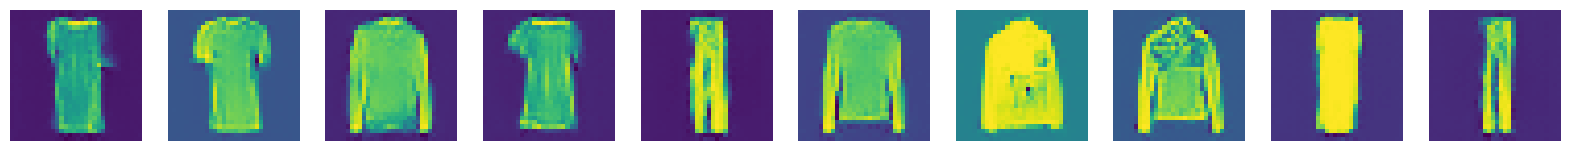

117/117 [==============================] - 29s 243ms/step - d_loss: 0.6490 - d_real_acc: 0.6111 - d_fake_acc: 0.6061 - d_acc: 0.6086 - g_loss: 0.8293 - g_acc: 0.3939
Epoch 72/100
117/117 [==============================] - ETA: 0s - d_loss: 0.6483 - d_real_acc: 0.6077 - d_fake_acc: 0.6118 - d_acc: 0.6098 - g_loss: 0.8339 - g_acc: 0.3882
Saved to ./output/output_dcgan/generated_img_071.png


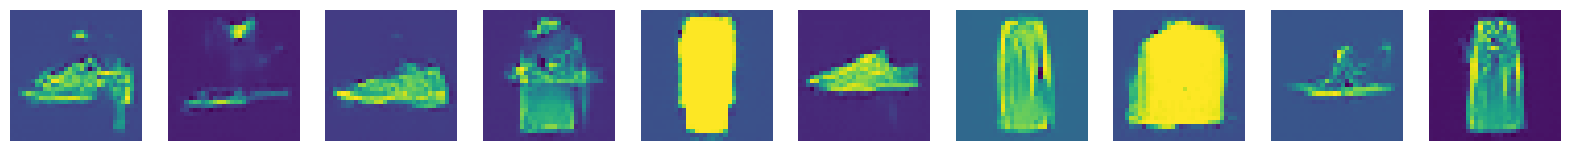

117/117 [==============================] - 28s 243ms/step - d_loss: 0.6483 - d_real_acc: 0.6077 - d_fake_acc: 0.6118 - d_acc: 0.6098 - g_loss: 0.8339 - g_acc: 0.3882
Epoch 73/100
117/117 [==============================] - ETA: 0s - d_loss: 0.6497 - d_real_acc: 0.6115 - d_fake_acc: 0.6058 - d_acc: 0.6087 - g_loss: 0.8264 - g_acc: 0.3942
Saved to ./output/output_dcgan/generated_img_072.png


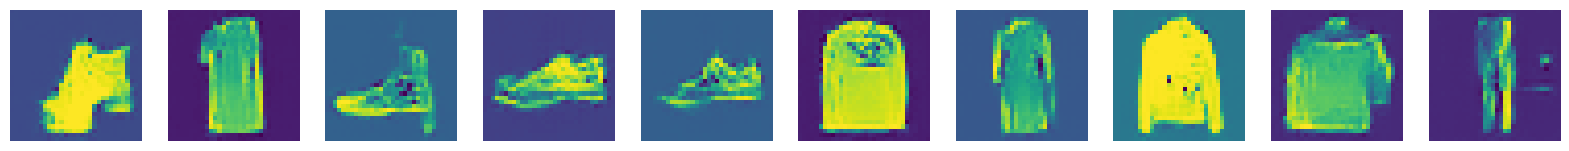

117/117 [==============================] - 28s 241ms/step - d_loss: 0.6497 - d_real_acc: 0.6115 - d_fake_acc: 0.6058 - d_acc: 0.6087 - g_loss: 0.8264 - g_acc: 0.3942
Epoch 74/100
117/117 [==============================] - ETA: 0s - d_loss: 0.6486 - d_real_acc: 0.6115 - d_fake_acc: 0.6086 - d_acc: 0.6100 - g_loss: 0.8298 - g_acc: 0.3914
Saved to ./output/output_dcgan/generated_img_073.png


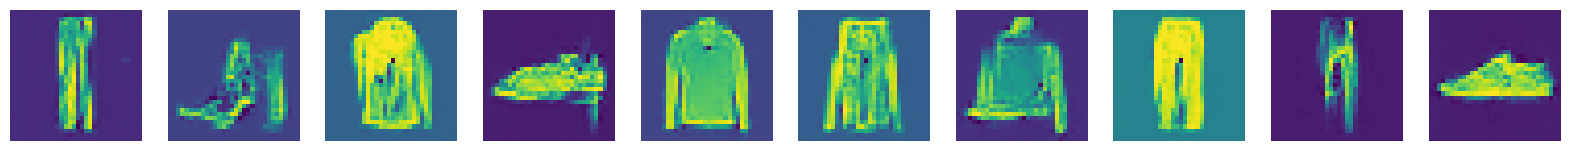

117/117 [==============================] - 28s 238ms/step - d_loss: 0.6486 - d_real_acc: 0.6115 - d_fake_acc: 0.6086 - d_acc: 0.6100 - g_loss: 0.8298 - g_acc: 0.3914
Epoch 75/100
117/117 [==============================] - ETA: 0s - d_loss: 0.6505 - d_real_acc: 0.6071 - d_fake_acc: 0.6062 - d_acc: 0.6067 - g_loss: 0.8293 - g_acc: 0.3938
Saved to ./output/output_dcgan/generated_img_074.png


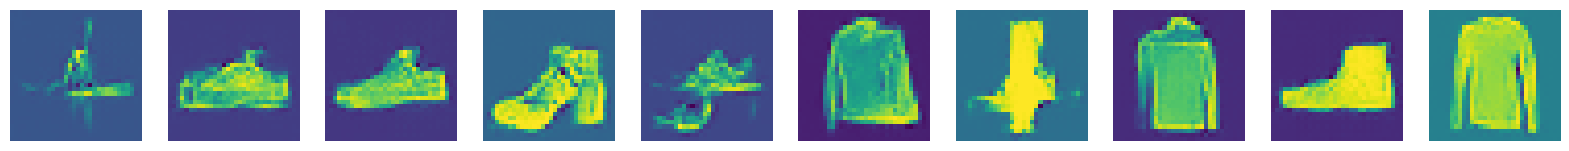

117/117 [==============================] - 28s 239ms/step - d_loss: 0.6505 - d_real_acc: 0.6071 - d_fake_acc: 0.6062 - d_acc: 0.6067 - g_loss: 0.8293 - g_acc: 0.3938
Epoch 76/100
117/117 [==============================] - ETA: 0s - d_loss: 0.6469 - d_real_acc: 0.6127 - d_fake_acc: 0.6089 - d_acc: 0.6108 - g_loss: 0.8303 - g_acc: 0.3911
Saved to ./output/output_dcgan/generated_img_075.png


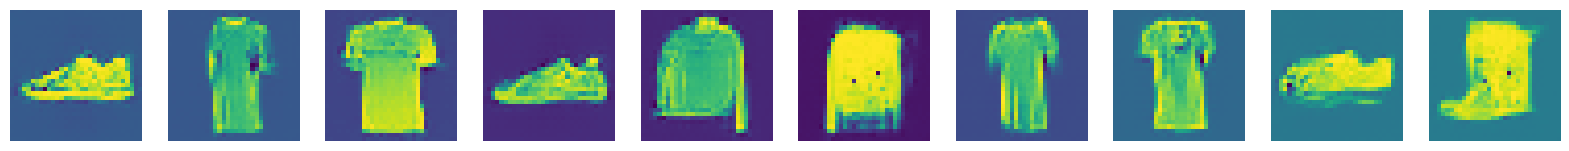

117/117 [==============================] - 28s 239ms/step - d_loss: 0.6469 - d_real_acc: 0.6127 - d_fake_acc: 0.6089 - d_acc: 0.6108 - g_loss: 0.8303 - g_acc: 0.3911
Epoch 77/100
117/117 [==============================] - ETA: 0s - d_loss: 0.6443 - d_real_acc: 0.6173 - d_fake_acc: 0.6128 - d_acc: 0.6151 - g_loss: 0.8386 - g_acc: 0.3872
Saved to ./output/output_dcgan/generated_img_076.png


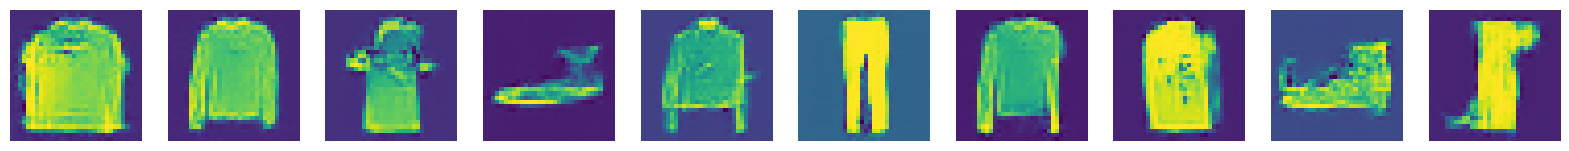

117/117 [==============================] - 28s 242ms/step - d_loss: 0.6443 - d_real_acc: 0.6173 - d_fake_acc: 0.6128 - d_acc: 0.6151 - g_loss: 0.8386 - g_acc: 0.3872
Epoch 78/100
117/117 [==============================] - ETA: 0s - d_loss: 0.6497 - d_real_acc: 0.6098 - d_fake_acc: 0.6082 - d_acc: 0.6090 - g_loss: 0.8335 - g_acc: 0.3918
Saved to ./output/output_dcgan/generated_img_077.png


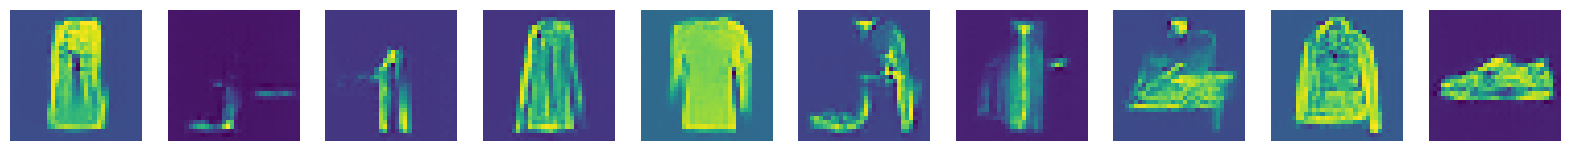

117/117 [==============================] - 28s 239ms/step - d_loss: 0.6497 - d_real_acc: 0.6098 - d_fake_acc: 0.6082 - d_acc: 0.6090 - g_loss: 0.8335 - g_acc: 0.3918
Epoch 79/100
117/117 [==============================] - ETA: 0s - d_loss: 0.6451 - d_real_acc: 0.6175 - d_fake_acc: 0.6124 - d_acc: 0.6150 - g_loss: 0.8368 - g_acc: 0.3876
Saved to ./output/output_dcgan/generated_img_078.png


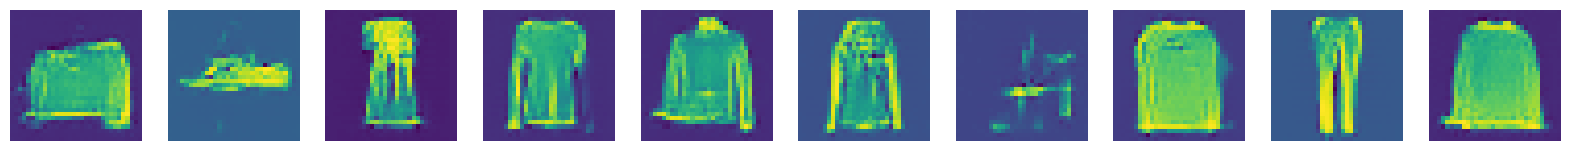

117/117 [==============================] - 28s 242ms/step - d_loss: 0.6451 - d_real_acc: 0.6175 - d_fake_acc: 0.6124 - d_acc: 0.6150 - g_loss: 0.8368 - g_acc: 0.3876
Epoch 80/100
117/117 [==============================] - ETA: 0s - d_loss: 0.6501 - d_real_acc: 0.6080 - d_fake_acc: 0.6093 - d_acc: 0.6086 - g_loss: 0.8321 - g_acc: 0.3907
Saved to ./output/output_dcgan/generated_img_079.png


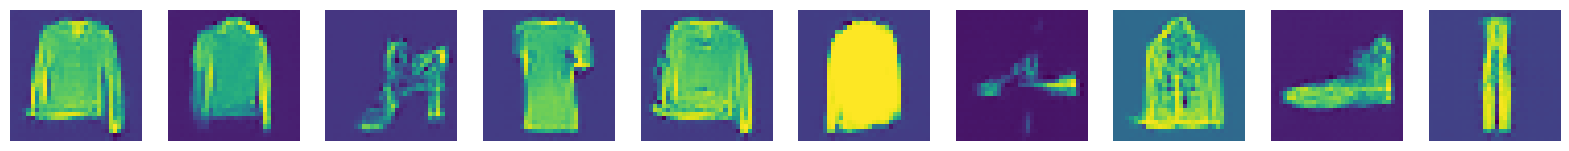

117/117 [==============================] - 28s 239ms/step - d_loss: 0.6501 - d_real_acc: 0.6080 - d_fake_acc: 0.6093 - d_acc: 0.6086 - g_loss: 0.8321 - g_acc: 0.3907
Epoch 81/100
117/117 [==============================] - ETA: 0s - d_loss: 0.6452 - d_real_acc: 0.6139 - d_fake_acc: 0.6135 - d_acc: 0.6137 - g_loss: 0.8390 - g_acc: 0.3865
Saved to ./output/output_dcgan/generated_img_080.png


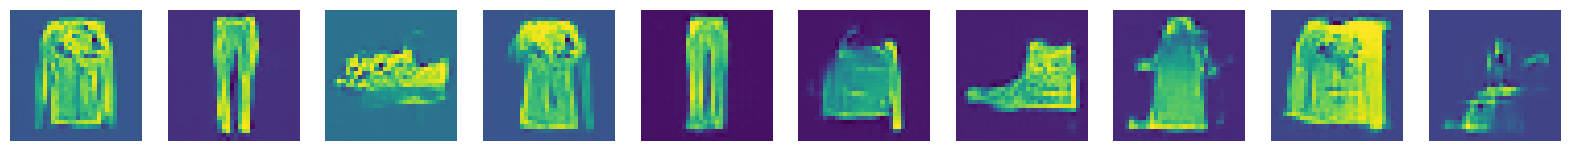

117/117 [==============================] - 28s 243ms/step - d_loss: 0.6452 - d_real_acc: 0.6139 - d_fake_acc: 0.6135 - d_acc: 0.6137 - g_loss: 0.8390 - g_acc: 0.3865
Epoch 82/100
117/117 [==============================] - ETA: 0s - d_loss: 0.6488 - d_real_acc: 0.6087 - d_fake_acc: 0.6098 - d_acc: 0.6093 - g_loss: 0.8343 - g_acc: 0.3902
Saved to ./output/output_dcgan/generated_img_081.png


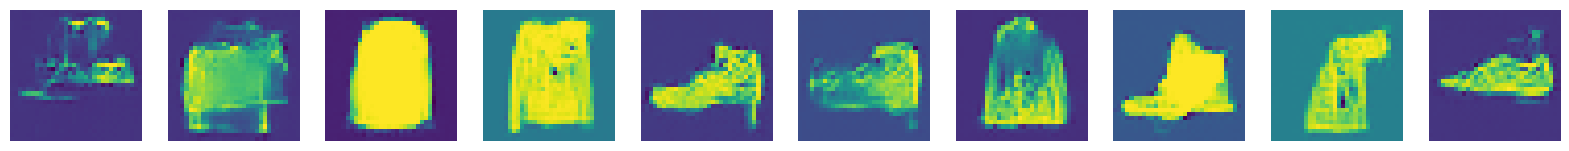

117/117 [==============================] - 28s 240ms/step - d_loss: 0.6488 - d_real_acc: 0.6087 - d_fake_acc: 0.6098 - d_acc: 0.6093 - g_loss: 0.8343 - g_acc: 0.3902
Epoch 83/100
117/117 [==============================] - ETA: 0s - d_loss: 0.6501 - d_real_acc: 0.6106 - d_fake_acc: 0.6064 - d_acc: 0.6085 - g_loss: 0.8317 - g_acc: 0.3936
Saved to ./output/output_dcgan/generated_img_082.png


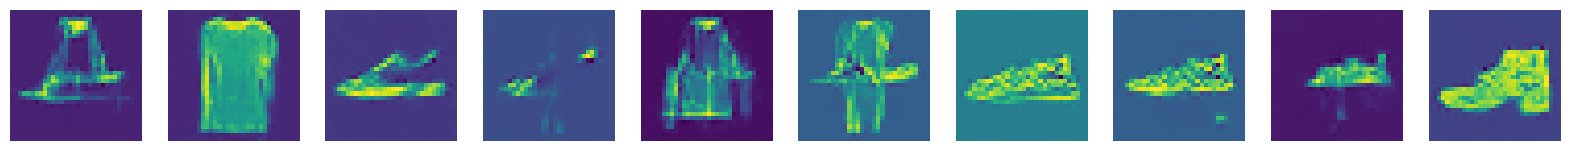

117/117 [==============================] - 28s 243ms/step - d_loss: 0.6501 - d_real_acc: 0.6106 - d_fake_acc: 0.6064 - d_acc: 0.6085 - g_loss: 0.8317 - g_acc: 0.3936
Epoch 84/100
117/117 [==============================] - ETA: 0s - d_loss: 0.6484 - d_real_acc: 0.6133 - d_fake_acc: 0.6072 - d_acc: 0.6103 - g_loss: 0.8311 - g_acc: 0.3928
Saved to ./output/output_dcgan/generated_img_083.png


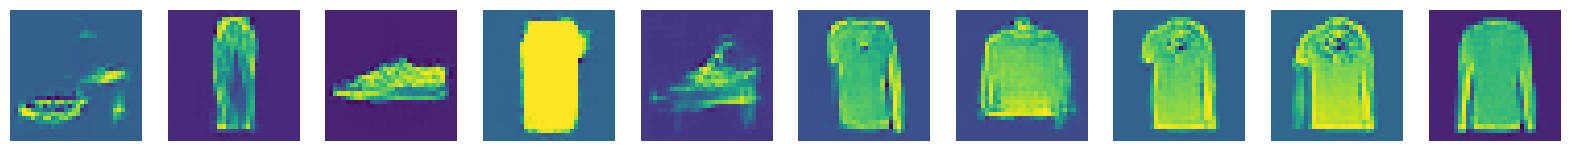

117/117 [==============================] - 28s 241ms/step - d_loss: 0.6484 - d_real_acc: 0.6133 - d_fake_acc: 0.6072 - d_acc: 0.6103 - g_loss: 0.8311 - g_acc: 0.3928
Epoch 85/100
117/117 [==============================] - ETA: 0s - d_loss: 0.6455 - d_real_acc: 0.6132 - d_fake_acc: 0.6146 - d_acc: 0.6139 - g_loss: 0.8390 - g_acc: 0.3854
Saved to ./output/output_dcgan/generated_img_084.png


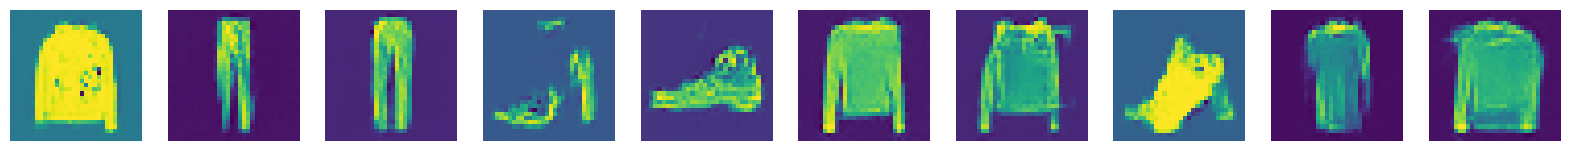

117/117 [==============================] - 28s 240ms/step - d_loss: 0.6455 - d_real_acc: 0.6132 - d_fake_acc: 0.6146 - d_acc: 0.6139 - g_loss: 0.8390 - g_acc: 0.3854
Epoch 86/100
117/117 [==============================] - ETA: 0s - d_loss: 0.6453 - d_real_acc: 0.6133 - d_fake_acc: 0.6108 - d_acc: 0.6121 - g_loss: 0.8353 - g_acc: 0.3892
Saved to ./output/output_dcgan/generated_img_085.png


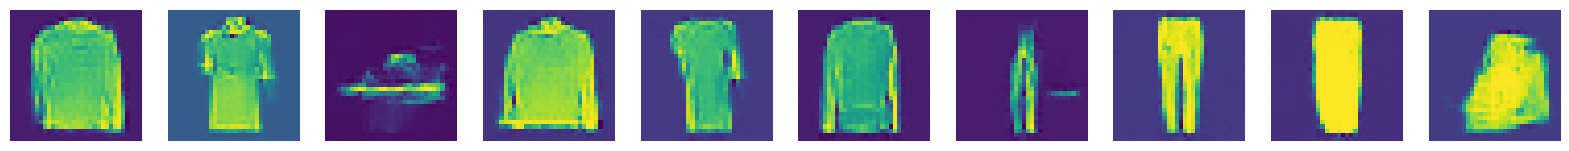

117/117 [==============================] - 28s 244ms/step - d_loss: 0.6453 - d_real_acc: 0.6133 - d_fake_acc: 0.6108 - d_acc: 0.6121 - g_loss: 0.8353 - g_acc: 0.3892
Epoch 87/100
117/117 [==============================] - ETA: 0s - d_loss: 0.6470 - d_real_acc: 0.6096 - d_fake_acc: 0.6122 - d_acc: 0.6109 - g_loss: 0.8345 - g_acc: 0.3878
Saved to ./output/output_dcgan/generated_img_086.png


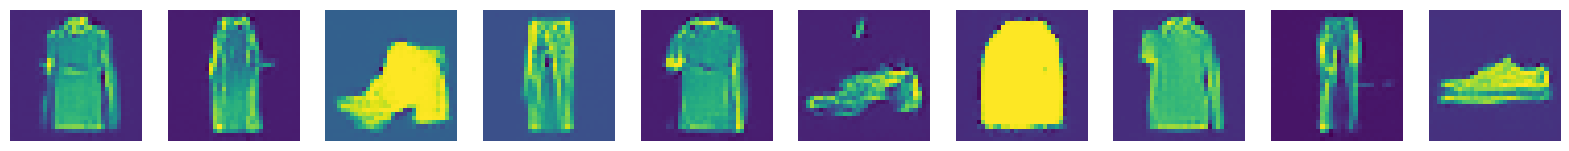

117/117 [==============================] - 29s 245ms/step - d_loss: 0.6470 - d_real_acc: 0.6096 - d_fake_acc: 0.6122 - d_acc: 0.6109 - g_loss: 0.8345 - g_acc: 0.3878
Epoch 88/100
117/117 [==============================] - ETA: 0s - d_loss: 0.6498 - d_real_acc: 0.6084 - d_fake_acc: 0.6102 - d_acc: 0.6093 - g_loss: 0.8341 - g_acc: 0.3898
Saved to ./output/output_dcgan/generated_img_087.png


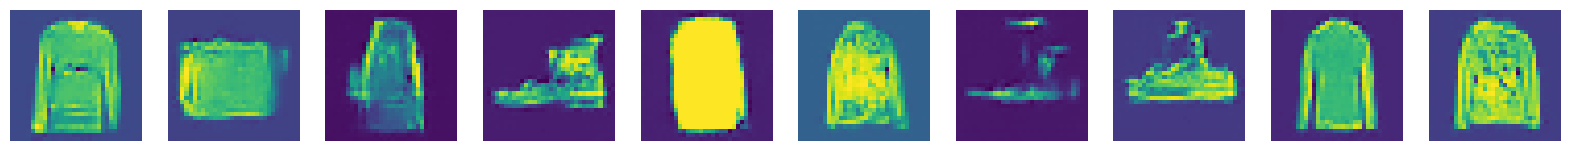

117/117 [==============================] - 28s 242ms/step - d_loss: 0.6498 - d_real_acc: 0.6084 - d_fake_acc: 0.6102 - d_acc: 0.6093 - g_loss: 0.8341 - g_acc: 0.3898
Epoch 89/100
117/117 [==============================] - ETA: 0s - d_loss: 0.6472 - d_real_acc: 0.6107 - d_fake_acc: 0.6131 - d_acc: 0.6119 - g_loss: 0.8350 - g_acc: 0.3869
Saved to ./output/output_dcgan/generated_img_088.png


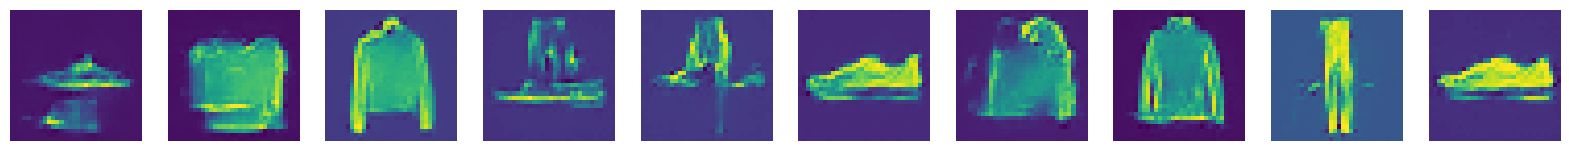

117/117 [==============================] - 28s 240ms/step - d_loss: 0.6472 - d_real_acc: 0.6107 - d_fake_acc: 0.6131 - d_acc: 0.6119 - g_loss: 0.8350 - g_acc: 0.3869
Epoch 90/100
117/117 [==============================] - ETA: 0s - d_loss: 0.6453 - d_real_acc: 0.6130 - d_fake_acc: 0.6172 - d_acc: 0.6151 - g_loss: 0.8386 - g_acc: 0.3828
Saved to ./output/output_dcgan/generated_img_089.png


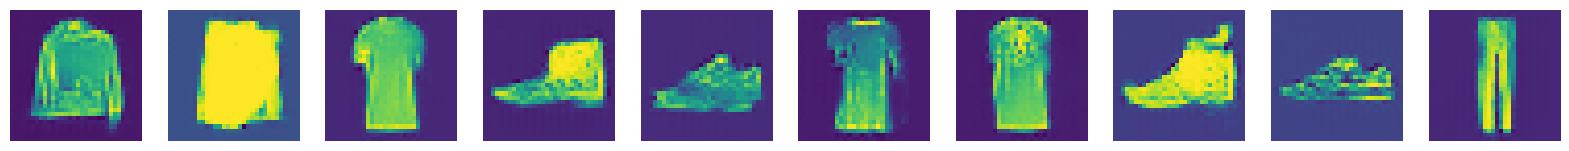

117/117 [==============================] - 28s 242ms/step - d_loss: 0.6453 - d_real_acc: 0.6130 - d_fake_acc: 0.6172 - d_acc: 0.6151 - g_loss: 0.8386 - g_acc: 0.3828
Epoch 91/100
117/117 [==============================] - ETA: 0s - d_loss: 0.6507 - d_real_acc: 0.6043 - d_fake_acc: 0.6081 - d_acc: 0.6062 - g_loss: 0.8347 - g_acc: 0.3919
Saved to ./output/output_dcgan/generated_img_090.png


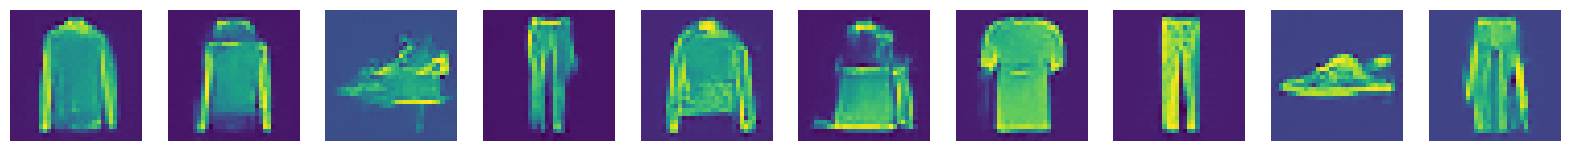

117/117 [==============================] - 29s 244ms/step - d_loss: 0.6507 - d_real_acc: 0.6043 - d_fake_acc: 0.6081 - d_acc: 0.6062 - g_loss: 0.8347 - g_acc: 0.3919
Epoch 92/100
117/117 [==============================] - ETA: 0s - d_loss: 0.6465 - d_real_acc: 0.6143 - d_fake_acc: 0.6105 - d_acc: 0.6124 - g_loss: 0.8356 - g_acc: 0.3895
Saved to ./output/output_dcgan/generated_img_091.png


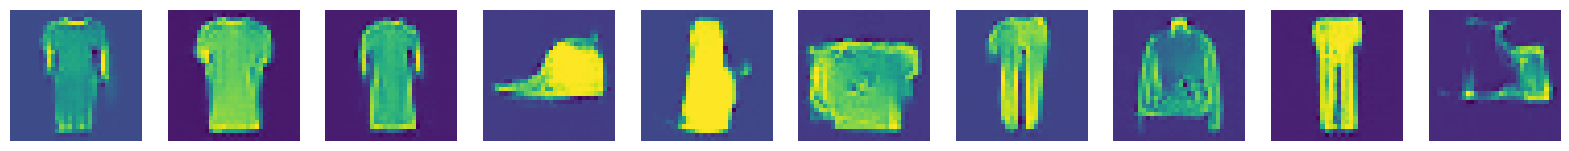

117/117 [==============================] - 29s 249ms/step - d_loss: 0.6465 - d_real_acc: 0.6143 - d_fake_acc: 0.6105 - d_acc: 0.6124 - g_loss: 0.8356 - g_acc: 0.3895
Epoch 93/100
117/117 [==============================] - ETA: 0s - d_loss: 0.6427 - d_real_acc: 0.6155 - d_fake_acc: 0.6204 - d_acc: 0.6179 - g_loss: 0.8419 - g_acc: 0.3796
Saved to ./output/output_dcgan/generated_img_092.png


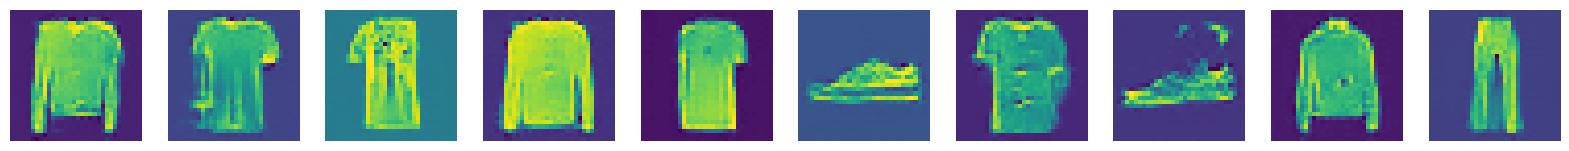

117/117 [==============================] - 28s 238ms/step - d_loss: 0.6427 - d_real_acc: 0.6155 - d_fake_acc: 0.6204 - d_acc: 0.6179 - g_loss: 0.8419 - g_acc: 0.3796
Epoch 94/100
117/117 [==============================] - ETA: 0s - d_loss: 0.6489 - d_real_acc: 0.6094 - d_fake_acc: 0.6118 - d_acc: 0.6106 - g_loss: 0.8366 - g_acc: 0.3882
Saved to ./output/output_dcgan/generated_img_093.png


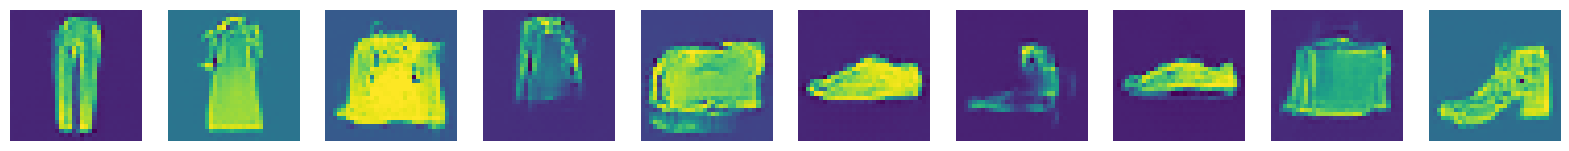

117/117 [==============================] - 28s 241ms/step - d_loss: 0.6489 - d_real_acc: 0.6094 - d_fake_acc: 0.6118 - d_acc: 0.6106 - g_loss: 0.8366 - g_acc: 0.3882
Epoch 95/100
117/117 [==============================] - ETA: 0s - d_loss: 0.6463 - d_real_acc: 0.6121 - d_fake_acc: 0.6138 - d_acc: 0.6130 - g_loss: 0.8359 - g_acc: 0.3862
Saved to ./output/output_dcgan/generated_img_094.png


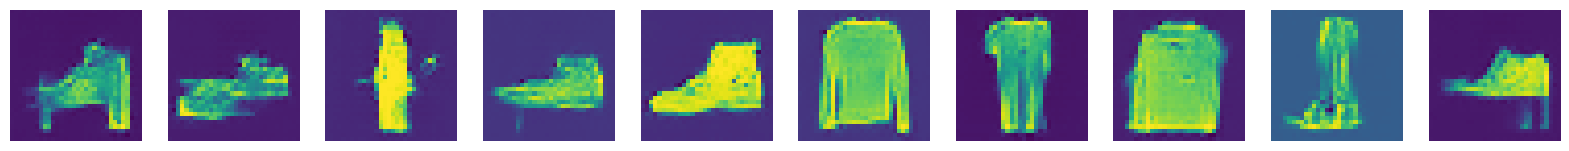

117/117 [==============================] - 28s 242ms/step - d_loss: 0.6463 - d_real_acc: 0.6121 - d_fake_acc: 0.6138 - d_acc: 0.6130 - g_loss: 0.8359 - g_acc: 0.3862
Epoch 96/100
117/117 [==============================] - ETA: 0s - d_loss: 0.6455 - d_real_acc: 0.6112 - d_fake_acc: 0.6167 - d_acc: 0.6140 - g_loss: 0.8387 - g_acc: 0.3833
Saved to ./output/output_dcgan/generated_img_095.png


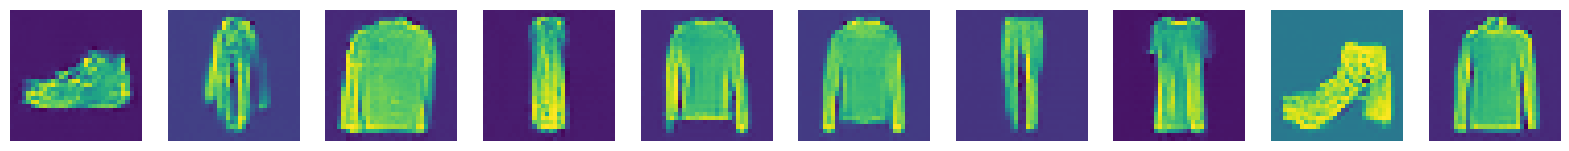

117/117 [==============================] - 28s 239ms/step - d_loss: 0.6455 - d_real_acc: 0.6112 - d_fake_acc: 0.6167 - d_acc: 0.6140 - g_loss: 0.8387 - g_acc: 0.3833
Epoch 97/100
117/117 [==============================] - ETA: 0s - d_loss: 0.6458 - d_real_acc: 0.6120 - d_fake_acc: 0.6135 - d_acc: 0.6127 - g_loss: 0.8395 - g_acc: 0.3865
Saved to ./output/output_dcgan/generated_img_096.png


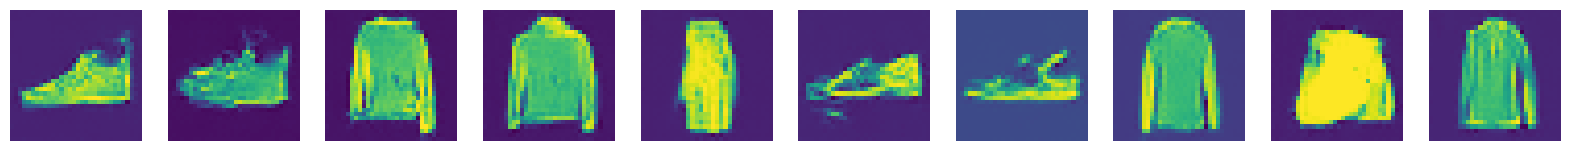

117/117 [==============================] - 28s 238ms/step - d_loss: 0.6458 - d_real_acc: 0.6120 - d_fake_acc: 0.6135 - d_acc: 0.6127 - g_loss: 0.8395 - g_acc: 0.3865
Epoch 98/100
117/117 [==============================] - ETA: 0s - d_loss: 0.6450 - d_real_acc: 0.6124 - d_fake_acc: 0.6155 - d_acc: 0.6139 - g_loss: 0.8415 - g_acc: 0.3845
Saved to ./output/output_dcgan/generated_img_097.png


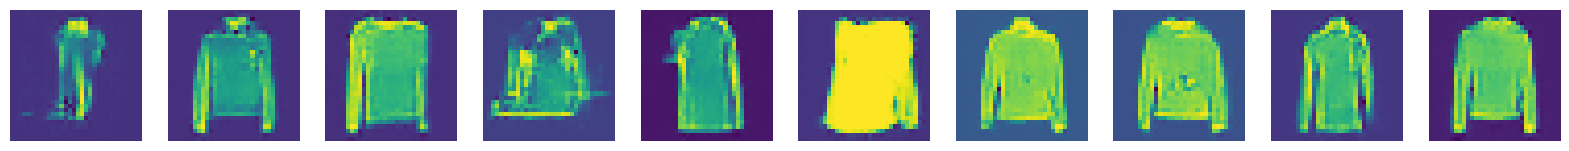

117/117 [==============================] - 28s 243ms/step - d_loss: 0.6450 - d_real_acc: 0.6124 - d_fake_acc: 0.6155 - d_acc: 0.6139 - g_loss: 0.8415 - g_acc: 0.3845
Epoch 99/100
117/117 [==============================] - ETA: 0s - d_loss: 0.6457 - d_real_acc: 0.6109 - d_fake_acc: 0.6157 - d_acc: 0.6133 - g_loss: 0.8410 - g_acc: 0.3843
Saved to ./output/output_dcgan/generated_img_098.png


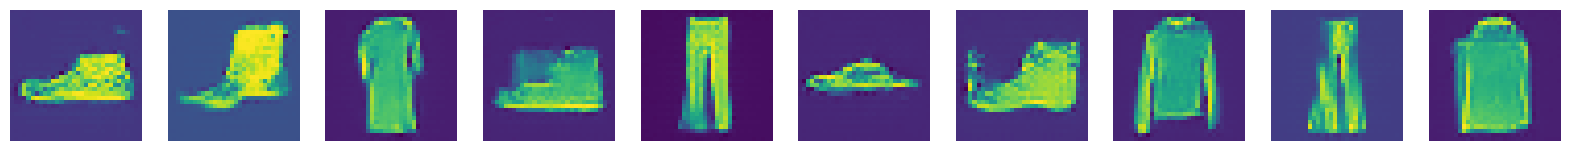

117/117 [==============================] - 28s 239ms/step - d_loss: 0.6457 - d_real_acc: 0.6109 - d_fake_acc: 0.6157 - d_acc: 0.6133 - g_loss: 0.8410 - g_acc: 0.3843
Epoch 100/100
117/117 [==============================] - ETA: 0s - d_loss: 0.6479 - d_real_acc: 0.6104 - d_fake_acc: 0.6146 - d_acc: 0.6125 - g_loss: 0.8380 - g_acc: 0.3854
Saved to ./output/output_dcgan/generated_img_099.png


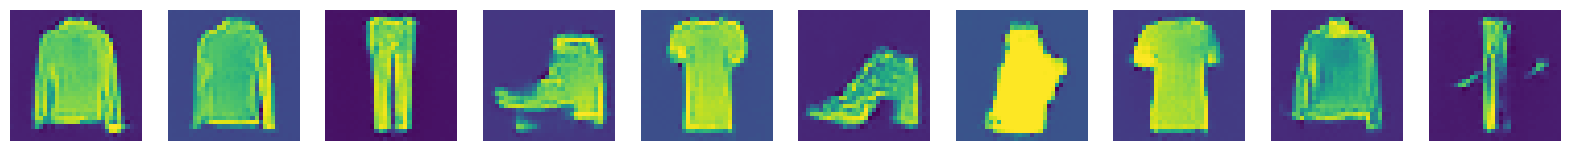

117/117 [==============================] - 28s 239ms/step - d_loss: 0.6479 - d_real_acc: 0.6104 - d_fake_acc: 0.6146 - d_acc: 0.6125 - g_loss: 0.8380 - g_acc: 0.3854
################################################## END TRAINING ##################################################


Saving Models...


NameError: name 'critic' is not defined

In [27]:
hisotry_dcgan, dcgan = train(dcgan,
                              "dcgan",
                              d_optimizer = optimizers.Adam(learning_rate=0.0001, beta_1=ADAM_BETA_1, beta_2=ADAM_BETA_2),
                              g_optimizer = optimizers.Adam(learning_rate=0.0002, beta_1=ADAM_BETA_1, beta_2=ADAM_BETA_2),
                              save_models=True,
                              plot_history=True,
                              load_model = False,
                              )

In [33]:
def generate_images(model, num_images):
    # Generate random noise
    noise = tf.random.normal([num_images, model.latent_dim])

    # Generate images from the noise
    generated_images = model.generator(noise, training=False)

    # Rescale the images from [-1, 1] to [0, 1]
    #generated_images = (generated_images + 1) / 2.0

    return generated_images.numpy()

# Generate 10k images
generated_images = generate_images(dcgan, 10000)

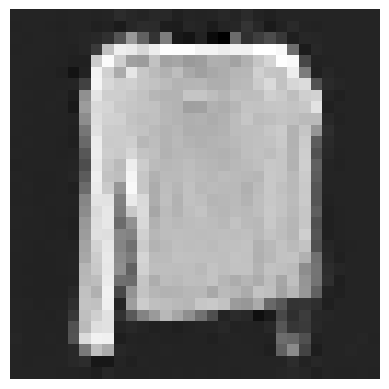

In [39]:
plt.imshow(generated_images[9].astype("float32"), cmap="gray")
plt.axis("off")
plt.show()

In [40]:
print(f"Generated images dataset shape: {generated_images.shape}")

Generated images dataset shape: (10000, 32, 32, 1)


In [41]:
test_data = test_data.astype(np.float32) / 255.0
test_data = np.pad(test_data, ((0, 0), (2, 2), (2, 2)),constant_values=0.)
test_data = np.expand_dims(test_data, axis=-1)

print(f"Test dataset shape: {test_data.shape}")

Test dataset shape: (10000, 32, 32, 1)


In [42]:
train_fid = get_fid(test_data, generated_images)

# Print out the results
print(f"FID(x_test, x_train) = {train_fid}")

Computing FID for (10000, 32, 32, 1) dimensional images
1/1 [==============================] - 13s 13s/step
Processed 100 images.
1/1 [==============================] - 0s 124ms/step
Processed 200 images.
1/1 [==============================] - 0s 135ms/step
Processed 300 images.
1/1 [==============================] - 0s 119ms/step
Processed 400 images.
1/1 [==============================] - 0s 119ms/step
Processed 500 images.
1/1 [==============================] - 0s 122ms/step
Processed 600 images.
1/1 [==============================] - 0s 119ms/step
Processed 700 images.
1/1 [==============================] - 0s 128ms/step
Processed 800 images.
1/1 [==============================] - 0s 120ms/step
Processed 900 images.
1/1 [==============================] - 0s 118ms/step
Processed 1000 images.
1/1 [==============================] - 0s 121ms/step
Processed 1100 images.
1/1 [==============================] - 0s 151ms/step
Processed 1200 images.
1/1 [==============================] - 0s 

In [ ]:
import shutil
from google.colab import files


images_path = './output'
models_path = './models'
log_path = './logs'
ckpt_path = './checkpoint'



models_zip = '/content/models'
images_zip = '/content/output'
log_zip =  '/content/logs'
ckpt_zip = '/content/checkpoint'



shutil.make_archive(models_zip, 'zip', models_path)
shutil.make_archive(images_zip, 'zip', images_path)
shutil.make_archive(log_zip, 'zip', log_path)
shutil.make_archive(ckpt_zip, 'zip', ckpt_path)


# Download the zip file
files.download('/content/models.zip')
files.download('/content/images.zip')
files.download('/content/logs.zip')
files.download('/content/checkpoint.zip')


## WGANSGP

In [43]:
IMG_SIZE = 32
CHANNELS = 1
BATCH_SIZE = 512
Z_DIM = 100
LEARNING_RATE = 0.0002
ADAM_BETA_1 = 0.5
ADAM_BETA_2 = 0.999
EPOCHS = 100
CRITIC_STEPS = 3
GP_WEIGHT = 10.0
LOAD_MODEL = False


In [44]:
class ConvBlockLayer(tf.keras.layers.Layer):
    def __init__(self, filters, kernel_size, strides=1, alpha=0.2,padding='same', use_bias=False, activation='relu',name:str=None):
        super(ConvBlockLayer, self).__init__(name=name)
        self.conv = tf.keras.layers.Conv2D(filters, kernel_size, strides=strides, padding=padding,use_bias=use_bias)
        self.activation = tf.keras.layers.LeakyReLU(alpha=alpha) if activation == 'leakyrelu' else tf.keras.layers.ReLU()

    def call(self, inputs):
        x = self.conv(inputs)
        x = self.activation(x)
        return x

class Upsampling(layers.Layer):
    def __init__(self, filters, kernel_size, strides=1, alpha=0.2, momentum=0.9, padding='same',activation=None, batchnorm=True, leakyrelu=True, use_bias=False, name:str=None):
        super(Upsampling, self).__init__(name=name)
        self.batchnorm_flag=batchnorm
        self.leakyrelu_flag=leakyrelu
        self.conv_transpose = layers.Conv2DTranspose(filters, kernel_size, strides=strides, padding=padding,use_bias=use_bias,activation=activation)
        self.batchnorm = layers.BatchNormalization(momentum=momentum) if momentum is not None else None
        self.leakyrelu = layers.LeakyReLU(alpha=alpha) if self.leakyrelu_flag else tf.keras.layers.ReLU()

    def call(self, inputs):
        x = self.conv_transpose(inputs)
        if self.batchnorm_flag:
          x = self.batchnorm(x)
        if self.leakyrelu_flag:
          x = self.leakyrelu(x)
        return x

In [ ]:
class Critic(tf.keras.Model):
    def __init__(self, critic_input_shape=(IMG_SIZE,IMG_SIZE,CHANNELS),name="Discriminator"):
        super(Critic, self).__init__(name=name)
        self.critic_input_shape = critic_input_shape
        self.model_layers= [
            layers.InputLayer(input_shape=self.critic_input_shape,name="InputLayer"),
            ConvBlockLayer(64, kernel_size=4, strides=2,alpha=0.2, padding='same', use_bias=False, activation='leakyrelu',name="ConvBlock_1"),
            layers.Dropout(0.3,name="Dropout_1"),
            ConvBlockLayer(128,kernel_size=4, strides=2,alpha=0.2, padding='same',use_bias=False, activation='leakyrelu',name="ConvBlock_2" ),
            layers.Dropout(0.3, name="Dropout_2"),
            ConvBlockLayer(256,kernel_size=4, strides=2,alpha=0.2,padding="same", use_bias=False,activation='leakyrelu', name="ConvBlock_3"),
            layers.Dropout(0.3, name="Dropout_3"),
            layers.Flatten(name="Flatten"),
            layers.Dropout(0.3,name="Dropout_2"),
            layers.Dense(1,activation='linear',name="Dense")
        ]


    def call(self,x):
      for layer in self.model_layers:
        x = layer(x)
      return x


In [ ]:
critic = Critic()
critic.build((None,IMG_SIZE,IMG_SIZE,CHANNELS))
critic.summary()

In [ ]:
class Generator(tf.keras.Model):
    def __init__(self,generator_input_shape=(Z_DIM,), name="Generator"):
        super(Generator, self).__init__(name=name)
        self.generator_input_shape = generator_input_shape
        self.model_layers = [
            layers.InputLayer(input_shape=self.generator_input_shape,name="InputLayer"),
            layers.Dense((4 * 4 * 512),name="Dense"),
            layers.BatchNormalization(name="BatchNorm_1"),
            layers.LeakyReLU(0.2,name="LeakyReLU_1"),
            layers.Reshape((4,4,512),name="Reshape"),
            Upsampling(256, kernel_size=4, strides=2, padding="same",alpha=0.2, momentum=0.9, use_bias=False,name="Upsampling_1"),
            Upsampling(128, kernel_size=5, strides=2, padding="same",alpha=0.2, momentum=0.9, use_bias=False,name="Upsampling_2"),
            Upsampling(64, kernel_size=5, strides=2, padding="same",alpha=0.2, momentum=0.9, use_bias=False,name="Upsampling_3"),
            Upsampling(CHANNELS,kernel_size=5, padding="same",activation="tanh",batchnorm=False,leakyrelu=False,use_bias=False,name="Gen_Output")
        ]

    def call(self,x):
        for layer in self.model_layers:
          x = layer(x)
        return x


In [ ]:
generator = Generator()
generator.build((None,100))
generator.summary()

In [ ]:
class WGANGP(tf.keras.Model):
    def __init__(self, critic, generator, latent_dim, critic_steps, gp_weight):
        super(WGANGP, self).__init__()
        self.critic = critic
        self.generator = generator
        self.latent_dim = latent_dim
        self.critic_steps = critic_steps
        self.gp_weight = gp_weight

    def compile(self, d_optimizer, g_optimizer):
        super(WGANGP, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.c_wass_loss_metric = metrics.Mean(name="c_wass_loss")
        self.c_gp_metric = metrics.Mean(name="c_gp")
        self.c_loss_metric = metrics.Mean(name="c_loss")
        self.g_loss_metric = metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [
            self.c_loss_metric,
            self.c_wass_loss_metric,
            self.c_gp_metric,
            self.g_loss_metric,
        ]

    def gradient_penalty(self, batch_size, real_images, fake_images):
        #each image in the batch gets a random number, between 0 and 1, stored as the vector alpha
        alpha = tf.random.normal([batch_size, 1, 1, 1], 0.0, 1.0)
        diff = fake_images - real_images
        # a set of interpolated images is calculated
        interpolated = real_images + alpha * diff

        with tf.GradientTape() as gp_tape:
            gp_tape.watch(interpolated)
            #score each of these interpolated image
            pred = self.critic(interpolated, training=True)

        #the gradient of the predictions is calculated with respect to the input images
        grads = gp_tape.gradient(pred, [interpolated])[0]
        norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2, 3]))   #L2 norm
        gp = tf.reduce_mean((norm - 1.0) ** 2)    #average squared distance between the L2 norm and 1
        return gp

    def train_step(self, real_images):
        batch_size = tf.shape(real_images)[0]

        #perform three critic updates
        for i in range(self.critic_steps):
            random_latent_vectors = tf.random.normal(
                shape=(batch_size, self.latent_dim)
            )

            with tf.GradientTape() as tape:
                fake_images = self.generator(
                    random_latent_vectors, training=True
                )
                fake_predictions = self.critic(fake_images, training=True)
                real_predictions = self.critic(real_images, training=True)

                #Wasserstein loss for the critic
                c_wass_loss = tf.reduce_mean(fake_predictions) - tf.reduce_mean(real_predictions)
                c_gp = self.gradient_penalty(
                    batch_size, real_images, fake_images                      #gradient penalty term
                )
                #the critic loss function is a weighted sum of the Wasserstein loss and the gradient penalty.
                c_loss = c_wass_loss + c_gp * self.gp_weight

            c_gradient = tape.gradient(c_loss, self.critic.trainable_variables)
            self.d_optimizer.apply_gradients(
                zip(c_gradient, self.critic.trainable_variables)               #Update the weights of the critic
            )

        random_latent_vectors = tf.random.normal(
            shape=(batch_size, self.latent_dim)
        )
        with tf.GradientTape() as tape:
            fake_images = self.generator(random_latent_vectors, training=True)
            fake_predictions = self.critic(fake_images, training=True)

            #Calculate the Wasserstein loss for the generator
            g_loss = -tf.reduce_mean(fake_predictions)

        gen_gradient = tape.gradient(g_loss, self.generator.trainable_variables)
        self.g_optimizer.apply_gradients(
            zip(gen_gradient, self.generator.trainable_variables)               #Update the weights of the generator
        )

        self.c_loss_metric.update_state(c_loss)
        self.c_wass_loss_metric.update_state(c_wass_loss)
        self.c_gp_metric.update_state(c_gp)
        self.g_loss_metric.update_state(g_loss)

        return {m.name: m.result() for m in self.metrics}

In [ ]:
#model instantiation
wgangp = WGANGP(
    critic=critic,
    generator=generator,
    latent_dim=Z_DIM,
    critic_steps=CRITIC_STEPS,
    gp_weight=GP_WEIGHT,
)

In [ ]:
train(wgangp,
      d_optimizer=optimizers.Adam(learning_rate=LEARNING_RATE, beta_1=ADAM_BETA_1, beta_2=ADAM_BETA_2),
      g_optimizer=optimizers.Adam(learning_rate=LEARNING_RATE, beta_1=ADAM_BETA_1, beta_2=ADAM_BETA_2),
      save_models=True,
      plot_history=True,
      load_model=LOAD_MODEL)

In [ ]:
z_sample = np.random.normal(size=(10, Z_DIM))
imgs = wgangp.generator.predict(z_sample)
plot_images(imgs, cmap=None)

In [42]:
import shutil
from google.colab import files


images_path = './output'
models_path = './models'
log_path = './logs'
ckpt_path = './checkpoint'



models_zip = '/content/models'
images_zip = '/content/images'
log_zip =  '/content/logs'
ckpt_zip = '/content/checkpoint'



shutil.make_archive(models_zip, 'zip', models_path)
shutil.make_archive(images_zip, 'zip', images_path)
shutil.make_archive(log_zip, 'zip', log_path)
shutil.make_archive(ckpt_zip, 'zip', ckpt_path)


# Download the zip file
files.download('/content/models.zip')
files.download('/content/images.zip')
files.download('/content/logs.zip')
files.download('/content/checkpoint.zip')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>